In [1]:
from dotenv import load_dotenv
load_dotenv('/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/.env')
%load_ext autoreload
%autoreload 2

MODEL_TO_AESTETICS = {
    'panopticon': ('blue', 'o', 'Panopticon'),
    'dofa': ('orange', 's', 'DOFA'),
    'senpamae': ('brown', 'x', 'SenPa-MAE'),
    'anysat_s2': ('green', '^', 'AnySat'),
    'anysat_spot': ('green', '^',  'AnySat'),
    'anysat_naip': ('green', '^',  'AnySat'),
    'galileo_s2': ('pink', 'P', 'Galileo'),
    'softcon_13b': ('purple', 'v',  'SoftCon'),
    'croma_12b': ('lightblue', 'D',  'CROMA'),
    'dinov2': ('red', 'D', 'DINOv2'),
    # 'senpamae_old': ('brown', 'P'),
}

def get_aestetics(model):

    for key, value in MODEL_TO_AESTETICS.items():
        if key in model:
            return value
    raise ValueError(f"Model {model} not found in aesthetics mapping.")

### Representation quality eurosat

In [10]:
""" single channel """
import os
import pandas as pd
from geobreeze.datasets.utils.utils import load_ds_cfg
from geobreeze.collect_results import collect_csv   

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_spec_inv/also_train/m-eurosat/'
collect_csv(p)

df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])

df = df[df['metric'] == 'acc_top-1_micro']

df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
df = df[df['model'] == 'panopticon']

df['train_mode'] = df['relpath'].apply(lambda x: x.split('/')[1])

df['prc'] = df['relpath'].apply(lambda x: float(x.split('/')[2]))
df['nchns'] = df['relpath'].apply(lambda x: int(x.split('/')[3]))
df['chn_ids'] = df['relpath'].apply(lambda x: eval(x.split('/')[4]))

df_og = df.copy()


In [71]:
""" get mean and std from single channels """
df = df_og.copy()

df = df[df['train_mode'] == 'linear_probe']
df = df[df['nchns'] == 1]
df = df[df['prc'] == 100]
df['chn_id'] = df['chn_ids'].apply(lambda x: x[0])

df = df.groupby(['chn_id'])['val'].agg('max')
print(df.mean(), df.std())

0.8231538465389838 0.1575165857980373


In [32]:
df = df_og.copy()
df = df[df['train_mode'] == 'linear_probe']
df = df[df['nchns'] == 1]
df['chn_id'] = df['chn_ids'].apply(lambda x: x[0])

df = df.groupby(['prc', 'chn_id'])['val'].agg('max').reset_index()
df = df.pivot(index='prc', columns='chn_id', values='val')

df = round(df * 100, 1)

df = df.rename(columns={0: 'B01', 1: 'B02', 2: 'B03', 3: 'B04', 4: 'B05', 5: 'B06', 6: 'B07', 7: 'B08', 8: 'B8A', 9: 'B09', 10: 'B10', 11: 'B11', 12: 'B12'})
df = df.sort_index(ascending=False)
# df = df.rename(index={16.6: '1/6', 25.0: '1/4', 33.3: '1/3', 50.0: '1/2', 100.0: '1'})

bands = load_ds_cfg('m-eurosat')['bands']
gsds = [int(b['GSD']) for b in bands]
df.loc['GSD'] = gsds

print(df.to_latex())

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
chn\_id &   B01 &   B02 &   B03 &   B04 &   B05 &   B06 &   B07 &   B08 &   B8A &   B09 &   B10 &   B11 &   B12 \\
prc   &       &       &       &       &       &       &       &       &       &       &       &       &       \\
\midrule
100.0 &  67.3 &  92.1 &  94.0 &  92.5 &  89.5 &  86.5 &  87.3 &  93.0 &  63.2 &  40.6 &  86.4 &  88.6 &  89.1 \\
50.0  &  68.4 &  90.8 &  91.3 &  90.9 &  90.1 &  85.7 &  85.6 &  90.6 &  61.5 &  39.6 &  85.4 &  86.5 &  84.5 \\
33.3  &  67.0 &  85.3 &  86.3 &  86.3 &  86.5 &  81.9 &  81.5 &  82.8 &  61.8 &  41.2 &  82.3 &  84.0 &  82.4 \\
25.0  &  64.7 &  79.6 &  79.4 &  82.2 &  81.2 &  76.6 &  75.0 &  78.0 &  60.3 &  40.4 &  80.8 &  81.4 &  78.9 \\
16.6  &  65.6 &  70.7 &  71.3 &  73.6 &  73.1 &  69.9 &  66.8 &  68.2 &  59.2 &  38.1 &  73.8 &  76.8 &  70.5 \\
GSD   &  60.0 &  10.0 &  10.0 &  10.0 &  20.0 &  20.0 &  20.0 &  10.0 &  20.0 &  60.0 &  60.0 &  20.0 &  20.0 \\
\bottomrule
\end{tabular}



/scratch/ipykernel_1550274/3728673241.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


In [12]:
""" single channel analysis """

def fun(train_mode):
    print(train_mode)
    df = df_og.copy()

    df = df[df['train_mode'] == train_mode]
    df = df[df['nchns'] == 1]

    df['chn_id'] = df['chn_ids'].apply(lambda x: x[0])
    df['prc'] = df['prc'].astype(float)
    df = df[df['prc'] != 12.5]

    df = df.groupby(['prc','chn_id']).agg({'val':'max'}).reset_index()
    if df['val'].max() <= 1.0:
        df['val'] = df['val'] * 100

    # print individual channels
    dfp = df.pivot(index='prc', columns='chn_id', values='val')
    dfp = round(dfp, 1)
    dfp.sort_index(ascending=False, inplace=True)
    # display(dfp)


    # print effective gsd
    bands = load_ds_cfg('m-eurosat')['bands']
    gsds = [b['GSD'] for b in bands]
    df['native_gsd'] = df['chn_id'].apply(lambda x: gsds[x])
    df['effective_gsd'] = (df['native_gsd'] / (df['prc']/100)).astype(int)

    _dfp = df.groupby('effective_gsd')['val'].agg(['mean','std'])

    dfp = df.groupby(['native_gsd','effective_gsd'])['val'].agg(['mean','std','count','min','max']).reset_index()
    dfp['pretty'] = dfp['mean'].round(1).astype(str) + ' ± ' + dfp['std'].round(1).fillna(0).astype(str)
    # dfp['pretty'] = dfp['min'].round(1).astype(str) + ' - ' + dfp['max'].round(1).fillna(0).astype(str)
    

    
    dfp = dfp.pivot(index='native_gsd', columns='effective_gsd', values='pretty')
    dfp = round(dfp, 1)
    # dfp.sort_index(ascending=False, inplace=True)
    # display(dfp)

    cols = [10,20,60]
    dfp: pd.DataFrame = dfp[cols]
    # dfp.loc['avg'] = _mean.round(1).astype(str) + ' ± ' + _std.round(1).fillna(0).astype(str)
    for c in cols:
        dfp.loc['all',c] = str(_dfp.loc[c,'mean'].round(1)) + ' ± ' + str(_dfp.loc[c,'std'].round(1))
    display(dfp)
    return dfp

dfp = fun('knn')
print(dfp.fillna('-').style.format(precision=1).to_latex())

dfp = fun('linear_probe')
print(dfp.fillna('-').style.format(precision=1).to_latex())


knn


effective_gsd,10,20,60
native_gsd,,,
10,90.2 ± 1.3,86.7 ± 1.3,67.4 ± 1.6
20,NaN,79.4 ± 11.8,74.1 ± 10.5
60,NaN,NaN,59.8 ± 21.4
all,90.2 ± 1.3,82.3 ± 9.6,68.8 ± 12.6


\begin{tabular}{llll}
effective_gsd & 10 & 20 & 60 \\
native_gsd &  &  &  \\
10 & 90.2 ± 1.3 & 86.7 ± 1.3 & 67.4 ± 1.6 \\
20 & - & 79.4 ± 11.8 & 74.1 ± 10.5 \\
60 & - & - & 59.8 ± 21.4 \\
all & 90.2 ± 1.3 & 82.3 ± 9.6 & 68.8 ± 12.6 \\
\end{tabular}

linear_probe


effective_gsd,10,20,60
native_gsd,,,
10,92.9 ± 0.8,90.9 ± 0.3,70.9 ± 2.2
20,NaN,84.0 ± 10.3,79.7 ± 8.9
60,NaN,NaN,64.8 ± 23.0
all,92.9 ± 0.8,86.8 ± 8.4,73.6 ± 12.8


\begin{tabular}{llll}
effective_gsd & 10 & 20 & 60 \\
native_gsd &  &  &  \\
10 & 92.9 ± 0.8 & 90.9 ± 0.3 & 70.9 ± 2.2 \\
20 & - & 84.0 ± 10.3 & 79.7 ± 8.9 \\
60 & - & - & 64.8 ± 23.0 \\
all & 92.9 ± 0.8 & 86.8 ± 8.4 & 73.6 ± 12.8 \\
\end{tabular}



In [13]:
""" multi-channel analysis """

def fun(train_mode, gsd_map={}):
    print(train_mode)
    df: pd.DataFrame = df_og.copy()

    df = df[df['train_mode'] == train_mode]
    df = df[df['nchns'] == 3]

    df['prc'] = df['prc'].astype(float)
    df = df[df['prc'] == 100]

    # df = df.groupby(['prc','chn_id']).agg({'val':'max'}).reset_index()
    if df['val'].max() <= 1.0:
        df['val'] = df['val'] * 100

    # max gsd
    bands = load_ds_cfg('m-eurosat')['bands']
    gsds = [b['GSD'] for b in bands]
    gsds = [gsd_map.get(i, i) for i in gsds]

    df = df.reset_index()
    df['lowest_chn_gsd'] = df['chn_ids'].apply(lambda x: min([gsds[i] for i in x]))
    for i in range(df.shape[0]):
        df.loc[i,'n_chn_lowest_gsd'] = len([j for j in df['chn_ids'][i] if gsds[j] == df['lowest_chn_gsd'][i]])

    dfp = df.groupby(['lowest_chn_gsd','n_chn_lowest_gsd'])['val'].agg(['mean','std','count']).reset_index()
    dfp['pretty'] = dfp['mean'].round(1).astype(str) + ' ± ' + dfp['std'].round(1).fillna(0).astype(str)
    # display(dfp.pivot(index='n_chn_lowest_gsd', columns='lowest_chn_gsd', values='count'))
    dfp = dfp.pivot(index='n_chn_lowest_gsd', columns='lowest_chn_gsd', values='pretty').fillna('-')
    dfp.index = dfp.index.astype(int)

    # dfp = dfp.sort_index(ascending=False)
    display(dfp)
    # print(dfp.style.to_latex())

    return dfp

dfp = fun('knn')
print(dfp.fillna('-').style.format(precision=1).to_latex())

dfp = fun('linear_probe')
print(dfp.fillna('-').style.format(precision=1).to_latex())

knn


lowest_chn_gsd,10,20,60
n_chn_lowest_gsd,,,
1,93.8 ± 0.9,84.5 ± 5.8,-
2,94.4 ± 0.8,88.7 ± 3.7,-
3,95.1 ± 0.2,92.5 ± 1.3,78.5 ± 0.0


\begin{tabular}{llll}
lowest_chn_gsd & 10 & 20 & 60 \\
n_chn_lowest_gsd &  &  &  \\
1 & 93.8 ± 0.9 & 84.5 ± 5.8 & - \\
2 & 94.4 ± 0.8 & 88.7 ± 3.7 & - \\
3 & 95.1 ± 0.2 & 92.5 ± 1.3 & 78.5 ± 0.0 \\
\end{tabular}

linear_probe


lowest_chn_gsd,10,20,60
n_chn_lowest_gsd,,,
1,95.5 ± 0.6,91.4 ± 2.0,-
2,96.0 ± 0.6,92.5 ± 1.6,-
3,96.2 ± 0.6,93.6 ± 1.2,85.5 ± 0.0


\begin{tabular}{llll}
lowest_chn_gsd & 10 & 20 & 60 \\
n_chn_lowest_gsd &  &  &  \\
1 & 95.5 ± 0.6 & 91.4 ± 2.0 & - \\
2 & 96.0 ± 0.6 & 92.5 ± 1.6 & - \\
3 & 96.2 ± 0.6 & 93.6 ± 1.2 & 85.5 ± 0.0 \\
\end{tabular}



### Domain Adapt

In [3]:
""" merge and compute averages """

import pandas as pd

df = pd.read_csv('/home/hk-project-pai00028/tum_mhj8661/code/avg.csv')

df = df[~ df['models'].isin(['SenPaMAE','DOFA','Panopticon'])]



def best_val(df):
    out = {}
    for c in df.columns[1:]:
        if c in ['SpaceNet1','FMoW-10\%','Corine-SD','Corine-MD']:
            out[c] = df[c].max()
        elif c in ['Hyperview-SD','Hyperview-MD','TC-10\%','DT-10\%']:
            out[c] = df[c].min()
        else:
            raise ValueError(c)
    return pd.Series(out)

# display(df)
pe = df[df['models'].isin(['Croma-PE','Softcon-PE','Anysat-PE'])].copy()
# display(pe)
pe_bestval = best_val(pe)
# display(pe_bestval)

# display(df)
match = df[df['models'].isin(['CROMA','SoftCon','AnySat'])].copy()
match_bestval = best_val(match)
# display(match)
# display(match_bestval)

# df.loc['avg_pe'] = pe.mean(axis=0)
# df.loc['avg_match'] = match.mean(axis=0)
# df.loc['best_pe'] = best_val(pe)
# df.loc['best_match'] = best_val(match)
# display(df)

# out df
dfp = pd.read_csv('/home/hk-project-pai00028/tum_mhj8661/code/avg.csv')
dfp = dfp[ dfp['models'].isin(['DINOv2','DINOv2-PE','SenPaMAE','DOFA','Panopticon'])]
dfp = dfp.set_index('models')
# dfp.loc['RSFM-Match'] = match_bestval
# dfp.loc['RSFM-PE'] = pe_bestval
dfp.loc['RSFM-Match'] = best_val(match)
dfp.loc['RSFM-PE'] = best_val(pe)

print(dfp.to_latex())


\begin{tabular}{lrrrrrrrr}
\toprule
{} &  SpaceNet1 &  FMoW-10\textbackslash \% &  Corine-SD &  Corine-MD &  Hyperview-SD &  Hyperview-MD &  TC-10\textbackslash \% &  DT-10\textbackslash \% \\
models     &            &            &            &            &               &               &          &          \\
\midrule
DINOv2-PE  &       90.0 &       29.2 &       66.8 &       63.6 &         1.043 &         0.639 &    0.635 &    0.502 \\
DINOv2     &       90.6 &       47.0 &       80.6 &       80.7 &         0.340 &         0.335 &    0.193 &    0.854 \\
SenPaMAE   &       86.2 &       16.9 &       64.2 &       62.7 &         0.366 &         0.355 &      NaN &      NaN \\
DOFA       &       89.9 &       42.0 &       81.0 &       80.2 &         0.334 &         0.338 &    0.385 &    1.032 \\
Panopticon &       90.3 &       50.3 &       85.8 &       86.2 &         0.313 &         0.321 &    0.315 &    0.963 \\
RSFM-Match &       90.2 &       29.0 &       81.3 &       83.5 &         0.339

/scratch/ipykernel_3991052/3833468598.py:49: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfp.to_latex())


In [72]:
""" pe results """
import os 
import pandas as pd
from geobreeze.collect_results import collect_csv


def fun(p, collect=True):
    if collect:
        collect_csv(p)
    df = pd.read_csv(os.path.join(p, 'results.csv')).drop(columns=['Unnamed: 0'])

    df['ds'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['train_mode'] = df['relpath'].apply(lambda x: x.split('/')[1])
    df['model'] = df['relpath'].apply(lambda x: x.split('/')[2])

    dfp = df[df['metric'].isin(['MulLabAvergPrec_micro', 'test/mIoU', 'MSE','acc_top-1_micro', 'test/MulLabAvergPrec_micro','test/MSE'])]

    dfp['val_max'] = dfp['val']
    dfp['val_min'] = dfp['val']
    dfp = dfp.groupby(['ds','model']).agg({'val_max': 'max', 'val_min': 'min'}).reset_index()

    for ds in ['hyperview-sd','hyperview-md','tropical_cyclone-10','digital_typhoon-10']:
        dfp.loc[dfp['ds'] == ds, 'val'] = dfp.loc[dfp['ds'] == ds, 'val_min']
    for ds in ['corine-sd','corine-md']:
        dfp.loc[dfp['ds'] == ds, 'val'] = dfp.loc[dfp['ds'] == ds, 'val_max']

    dfp = dfp.pivot(index='model', columns='ds', values='val')

    # order_ds = ['corine-sd','corine-md','hyperview-sd','hyperview-md']
    # dfp = dfp[order_ds]
    dfp.index = dfp.index.map(lambda x: MODEL_TO_AESTETICS[x][2])
    # order_models = ['CROMA','SoftCon','AnySat']
    # dfp = dfp.reindex(order_models)

    for ds in ['corine-sd','corine-md']:
        if ds in dfp:
            dfp[ds] = round(dfp[ds]*100,1)
    for ds in ['hyperview-sd','hyperview-md','tropical_cyclone-10','digital_typhoon-10']:
        if ds in dfp:
            dfp[ds] = round(dfp[ds],3)

    dfp.index = dfp.index.map(lambda x: x + '-PE')
    display(dfp)
    return dfp

# p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/domain_adapt/pe'
# fun(p, collect=False)

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/domain_adapt/pe_adamw'
dfp = fun(p, collect=False)

add_results = {
    ('CROMA-PE','spacenet1'): 89.4,
    ('SoftCon-PE','spacenet1'): 90.1,
    ('AnySat-PE','spacenet1'): 87.7,
    ('DINOv2-PE','spacenet1'): 90.0,

    # would like to redo
    ('CROMA-PE','fmow-10'): 33.7,
    ('SoftCon-PE','fmow-10'): 32.8,
    ('AnySat-PE','fmow-10'): 26.2,
    ('DINOv2-PE','fmow-10'): 29.2,
    ('DINOv2-PE','corine-sd'): 66.8,
    ('DINOv2-PE','corine-md'): 63.6,
    ('DINOv2-PE','hyperview-sd'): 1.043,
    ('DINOv2-PE','hyperview-md'): 0.639,
    ('DINOv2-PE','tropical_cyclone-10'): 0.635,
    ('DINOv2-PE','digital_typhoon-10'): 0.502,

}

for k,v in add_results.items():
    dfp.loc[k[0], k[1]] = v

display(dfp)
dfp_pe = dfp
# print(dfp.to_latex())

/scratch/ipykernel_3991052/3601721525.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['val_max'] = dfp['val']
/scratch/ipykernel_3991052/3601721525.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['val_min'] = dfp['val']


ds,corine-md,corine-sd,digital_typhoon-10,hyperview-md,hyperview-sd,tropical_cyclone-10
model,,,,,,
AnySat-PE,81.1,79.2,0.811,0.360,0.386,0.431
CROMA-PE,82.1,81.0,0.561,0.368,0.353,0.371
SoftCon-PE,81.6,80.9,0.568,0.399,0.359,0.437


ds,corine-md,corine-sd,digital_typhoon-10,hyperview-md,hyperview-sd,tropical_cyclone-10,spacenet1,fmow-10
model,,,,,,,,
AnySat-PE,81.1,79.2,0.811,0.360,0.386,0.431,87.7,26.2
CROMA-PE,82.1,81.0,0.561,0.368,0.353,0.371,89.4,33.7
SoftCon-PE,81.6,80.9,0.568,0.399,0.359,0.437,90.1,32.8
DINOv2-PE,63.6,66.8,0.502,0.639,1.043,0.635,90.0,29.2


In [73]:
""" match results """
import os 
import pandas as pd
from geobreeze.collect_results import collect_csv

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/domain_adapt/match'
# df = collect_csv(p)
df = pd.read_csv(os.path.join(p, 'results.csv')).drop(columns=['Unnamed: 0'])

df['ds'] = df['relpath'].apply(lambda x: x.split('/')[0])
df['train_mode'] = df['relpath'].apply(lambda x: x.split('/')[1])
df['model'] = df['relpath'].apply(lambda x: x.split('/')[2])

dfp = df[df['metric'].isin(['MulLabAvergPrec_micro', 'test/mIoU', 'MSE','acc_top-1_micro'])]

dfp = dfp.groupby(['ds','model']).agg({'val': 'max'}).reset_index()
dfp = dfp.pivot(index='model', columns='ds', values='val')
# display(dfp)

ds_order = ['spacenet1','fmow-10','corine-sd','corine-md','hyperview-sd','hyperview-md','tropical_cyclone-10', 'digital_typhoon-10',]
dfp = dfp[ds_order]
model_order = ['croma_12b','softcon_13b','anysat_s2']
dfp = dfp.reindex(model_order + [m for m in dfp.index if m not in model_order])
for m, vals in MODEL_TO_AESTETICS.items():
    if m in dfp.index:
        dfp.rename(index={m:vals[2]}, inplace=True)

add_results_dinov2 = {
    'spacenet1': 90.6,
    'fmow-10': 47.0,
    # 'corine-sd': 80.6,
    # 'corine-md': 80.7,
    'hyperview-sd': 0.340,
    'hyperview-md': 0.335,
    # 'tropical_cyclone-10': ?,
    # 'digital_typhoon-10': ?,
}


for c in ['spacenet1','fmow-10','corine-sd','corine-md',]:
    dfp[c] = round(dfp[c]*100, 1)
for c in ['digital_typhoon-10','hyperview-sd','hyperview-md','tropical_cyclone-10']:
    dfp[c] = round(dfp[c], 3)
for k,v in add_results_dinov2.items():
    dfp.loc['DINOv2', k] = v
display(dfp)

dfp_match = dfp

print(dfp.to_latex())

ds,spacenet1,fmow-10,corine-sd,corine-md,hyperview-sd,hyperview-md,tropical_cyclone-10,digital_typhoon-10
model,,,,,,,,
CROMA,89.5,29.0,78.2,81.6,0.342,0.340,0.809,1.058
SoftCon,90.2,29.5,81.3,83.5,0.339,0.347,0.812,1.013
AnySat,85.9,22.8,76.7,78.2,0.344,0.352,0.823,1.032
DINOv2,90.6,47.0,80.6,80.7,0.340,0.335,0.193,0.854


\begin{tabular}{lrrrrrrrr}
\toprule
ds &  spacenet1 &  fmow-10 &  corine-sd &  corine-md &  hyperview-sd &  hyperview-md &  tropical\_cyclone-10 &  digital\_typhoon-10 \\
model   &            &          &            &            &               &               &                      &                     \\
\midrule
CROMA   &       89.5 &     29.0 &       78.2 &       81.6 &         0.342 &         0.340 &                0.809 &               1.058 \\
SoftCon &       90.2 &     29.5 &       81.3 &       83.5 &         0.339 &         0.347 &                0.812 &               1.013 \\
AnySat  &       85.9 &     22.8 &       76.7 &       78.2 &         0.344 &         0.352 &                0.823 &               1.032 \\
DINOv2  &       90.6 &     47.0 &       80.6 &       80.7 &         0.340 &         0.335 &                0.193 &               0.854 \\
\bottomrule
\end{tabular}



/scratch/ipykernel_3991052/3717288967.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfp.to_latex())


In [85]:
""" merge and compute averages """

import pandas as pd

df = pd.concat([dfp_pe, dfp_match], axis=0)

col_map = {
    'spacenet1': 'SpaceNet1',
    'fmow-10': 'FMoW-10\%',
    'corine-sd': 'Corine-SD',
    'corine-md': 'Corine-MD',
    'hyperview-sd': 'Hyperview-SD',
    'hyperview-md': 'Hyperview-MD',
    'tropical_cyclone-10': 'TC-10\%',
    'digital_typhoon-10': 'DT-10\%',
}
for k,v in col_map.items():
    if k in df.columns:
        df.rename(columns={k: v}, inplace=True)

# start outdf
dfp = pd.read_csv('/home/hk-project-pai00028/tum_mhj8661/code/avg.csv')
dfp.rename(columns={'models': 'model'}, inplace=True)
dfp = dfp.set_index('model')
dfp = dfp[ dfp.index.isin(['SenPaMAE','DOFA','Panopticon'])]

def best_val(df):
    out = {}
    for c in df.columns:
        if c in ['SpaceNet1','FMoW-10\%','Corine-SD','Corine-MD']:
            out[c] = df[c].max()
        elif c in ['Hyperview-SD','Hyperview-MD','TC-10\%','DT-10\%']:
            out[c] = df[c].min()
        else:
            raise ValueError(c)
    return pd.Series(out)

# display(df)
pe = df[df.index.isin(['CROMA-PE','SoftCon-PE','AnySat-PE'])]
pe_bestval = best_val(pe)

# display(df)
match = df[df.index.isin(['CROMA','SoftCon','AnySat'])]
match_bestval = best_val(match)

# display full df
dffull = pd.concat([dfp, df])
display(dffull)
print(dffull.to_latex())

# finish outdf
dfp.loc['DINOv2'] = df.loc['DINOv2']
dfp.loc['DINOv2-PE'] = df.loc['DINOv2-PE']
dfp.loc['RSFM-Match'] = match_bestval
dfp.loc['RSFM-PE'] = pe_bestval

index_order = ['DINOv2','DINOv2-PE','RSFM-Match','RSFM-PE','SenPaMAE','DOFA','Panopticon']
dfp = dfp.reindex(index_order)

display(dfp)

print(dfp.to_latex())

,SpaceNet1,FMoW-10\%,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC-10\%,DT-10\%
model,,,,,,,,
SenPaMAE,86.2,16.9,64.2,62.7,0.366,0.355,NaN,NaN
DOFA,89.9,42.0,81.0,80.2,0.334,0.338,0.385,1.032
Panopticon,90.3,50.3,85.8,86.2,0.313,0.321,0.315,0.963
AnySat-PE,87.7,26.2,79.2,81.1,0.386,0.360,0.431,0.811
CROMA-PE,89.4,33.7,81.0,82.1,0.353,0.368,0.371,0.561
SoftCon-PE,90.1,32.8,80.9,81.6,0.359,0.399,0.437,0.568
DINOv2-PE,90.0,29.2,66.8,63.6,1.043,0.639,0.635,0.502
CROMA,89.5,29.0,78.2,81.6,0.342,0.340,0.809,1.058
SoftCon,90.2,29.5,81.3,83.5,0.339,0.347,0.812,1.013


\begin{tabular}{lrrrrrrrr}
\toprule
{} &  SpaceNet1 &  FMoW-10\textbackslash \% &  Corine-SD &  Corine-MD &  Hyperview-SD &  Hyperview-MD &  TC-10\textbackslash \% &  DT-10\textbackslash \% \\
model      &            &            &            &            &               &               &          &          \\
\midrule
SenPaMAE   &       86.2 &       16.9 &       64.2 &       62.7 &         0.366 &         0.355 &      NaN &      NaN \\
DOFA       &       89.9 &       42.0 &       81.0 &       80.2 &         0.334 &         0.338 &    0.385 &    1.032 \\
Panopticon &       90.3 &       50.3 &       85.8 &       86.2 &         0.313 &         0.321 &    0.315 &    0.963 \\
AnySat-PE  &       87.7 &       26.2 &       79.2 &       81.1 &         0.386 &         0.360 &    0.431 &    0.811 \\
CROMA-PE   &       89.4 &       33.7 &       81.0 &       82.1 &         0.353 &         0.368 &    0.371 &    0.561 \\
SoftCon-PE &       90.1 &       32.8 &       80.9 &       81.6 &         0.359

/scratch/ipykernel_3991052/2380025867.py:49: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dffull.to_latex())


,SpaceNet1,FMoW-10\%,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC-10\%,DT-10\%
model,,,,,,,,
DINOv2,90.6,47.0,80.6,80.7,0.340,0.335,0.193,0.854
DINOv2-PE,90.0,29.2,66.8,63.6,1.043,0.639,0.635,0.502
RSFM-Match,90.2,29.5,81.3,83.5,0.339,0.340,0.809,1.013
RSFM-PE,90.1,33.7,81.0,82.1,0.353,0.360,0.371,0.561
SenPaMAE,86.2,16.9,64.2,62.7,0.366,0.355,NaN,NaN
DOFA,89.9,42.0,81.0,80.2,0.334,0.338,0.385,1.032
Panopticon,90.3,50.3,85.8,86.2,0.313,0.321,0.315,0.963


\begin{tabular}{lrrrrrrrr}
\toprule
{} &  SpaceNet1 &  FMoW-10\textbackslash \% &  Corine-SD &  Corine-MD &  Hyperview-SD &  Hyperview-MD &  TC-10\textbackslash \% &  DT-10\textbackslash \% \\
model      &            &            &            &            &               &               &          &          \\
\midrule
DINOv2     &       90.6 &       47.0 &       80.6 &       80.7 &         0.340 &         0.335 &    0.193 &    0.854 \\
DINOv2-PE  &       90.0 &       29.2 &       66.8 &       63.6 &         1.043 &         0.639 &    0.635 &    0.502 \\
RSFM-Match &       90.2 &       29.5 &       81.3 &       83.5 &         0.339 &         0.340 &    0.809 &    1.013 \\
RSFM-PE    &       90.1 &       33.7 &       81.0 &       82.1 &         0.353 &         0.360 &    0.371 &    0.561 \\
SenPaMAE   &       86.2 &       16.9 &       64.2 &       62.7 &         0.366 &         0.355 &      NaN &      NaN \\
DOFA       &       89.9 &       42.0 &       81.0 &       80.2 &         0.334

/scratch/ipykernel_3991052/2380025867.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfp.to_latex())


In [88]:
_dfp = dfp.copy()

df = _dfp.copy()
for c in df.columns:
    if c in ['SpaceNet1','FMoW-10\%','Corine-SD','Corine-MD']:
        pass
    elif c in ['Hyperview-SD','Hyperview-MD','TC-10\%','DT-10\%']:
        df[c] = (1 - df[c].apply(lambda x: min(x, 1))) * 100
    else:
        raise ValueError(c)

_dfp['avg'] = round(df.mean(axis=1), 1)
_dfp

,SpaceNet1,FMoW-10\%,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC-10\%,DT-10\%,avg
model,,,,,,,,,
DINOv2,90.6,47.0,80.6,80.7,0.340,0.335,0.193,0.854,65.8
DINOv2-PE,90.0,29.2,66.8,63.6,1.043,0.639,0.635,0.502,46.5
RSFM-Match,90.2,29.5,81.3,83.5,0.339,0.340,0.809,1.013,54.5
RSFM-PE,90.1,33.7,81.0,82.1,0.353,0.360,0.371,0.561,65.3
SenPaMAE,86.2,16.9,64.2,62.7,0.366,0.355,NaN,NaN,59.6
DOFA,89.9,42.0,81.0,80.2,0.334,0.338,0.385,1.032,60.9
Panopticon,90.3,50.3,85.8,86.2,0.313,0.321,0.315,0.963,65.2


In [89]:
df

,SpaceNet1,FMoW-10\%,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC-10\%,DT-10\%
model,,,,,,,,
DINOv2,90.6,47.0,80.6,80.7,66.0,66.5,80.7,14.6
DINOv2-PE,90.0,29.2,66.8,63.6,0.0,36.1,36.5,49.8
RSFM-Match,90.2,29.5,81.3,83.5,66.1,66.0,19.1,0.0
RSFM-PE,90.1,33.7,81.0,82.1,64.7,64.0,62.9,43.9
SenPaMAE,86.2,16.9,64.2,62.7,63.4,64.5,NaN,NaN
DOFA,89.9,42.0,81.0,80.2,66.6,66.2,61.5,0.0
Panopticon,90.3,50.3,85.8,86.2,68.7,67.9,68.5,3.7


In [29]:
for c in dfp.columns:
    print(c)

SpaceNet1
FMoW-10\%
Corine-SD
Corine-MD
Hyperview-SD
Hyperview-MD
TC-10\%
DT-10\%


In [3]:
""" shuffle results """
import os 
import pandas as pd
from geobreeze.collect_results import collect_csv

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/domain_adapt/shuffle/'
df = collect_csv(p)
df = pd.read_csv(os.path.join(p, 'results.csv')).drop(columns=['Unnamed: 0'])

df['ds'] = df['relpath'].apply(lambda x: x.split('/')[0])
df['train_mode'] = df['relpath'].apply(lambda x: x.split('/')[1])
df['model'] = df['relpath'].apply(lambda x: x.split('/')[2])
df['ids'] = df['relpath'].apply(lambda x: x.split('/')[3])

dfp = df[df['metric'].isin(['acc_top-1_micro'])]

dfp

,metric,val,best_classifier,relpath,ds,train_mode,model,ids
2,acc_top-1_micro,87.330000,"('full_T=0,07_normf=batchwise', 5)","resisc45/knn/dinov2/[0,1,2]/k=[1, 3, 5, 10, 15...",resisc45,knn,dinov2,"[0,1,2]"
5,acc_top-1_micro,84.510000,"('full_T=0,07_normf=batchwise', 5)","resisc45/knn/dinov2/[0,2,1]/k=[1, 3, 5, 10, 15...",resisc45,knn,dinov2,"[0,2,1]"
8,acc_top-1_micro,84.970000,"('full_T=0,07_normf=batchwise', 10)","resisc45/knn/dinov2/[2,1,0]/k=[1, 3, 5, 10, 15...",resisc45,knn,dinov2,"[2,1,0]"
11,acc_top-1_micro,83.790000,"('full_T=0,07_normf=batchwise', 5)","resisc45/knn/dinov2/[1,2,0]/k=[1, 3, 5, 10, 15...",resisc45,knn,dinov2,"[1,2,0]"
14,acc_top-1_micro,85.680000,"('full_T=0,07_normf=batchwise', 5)","resisc45/knn/dinov2/[1,0,2]/k=[1, 3, 5, 10, 15...",resisc45,knn,dinov2,"[1,0,2]"
17,acc_top-1_micro,84.330000,"('full_T=0,07_normf=batchwise', 10)","resisc45/knn/dinov2/[2,0,1]/k=[1, 3, 5, 10, 15...",resisc45,knn,dinov2,"[2,0,1]"
20,acc_top-1_micro,0.943651,blocks_4_pooling_avgpool_lr_0_03906_1dbn_True,"resisc45/linear_probe/dinov2/[0,1,2]/bsz=200_e=50",resisc45,linear_probe,dinov2,"[0,1,2]"
23,acc_top-1_micro,0.937936,blocks_4_pooling_avgpool_lr_0_00781_1dbn_True,"resisc45/linear_probe/dinov2/[0,2,1]/bsz=200_e=50",resisc45,linear_probe,dinov2,"[0,2,1]"
26,acc_top-1_micro,0.940635,blocks_4_pooling_avgpool_lr_0_03906_1dbn_True,"resisc45/linear_probe/dinov2/[2,1,0]/bsz=200_e=50",resisc45,linear_probe,dinov2,"[2,1,0]"
29,acc_top-1_micro,0.936984,blocks_4_pooling_avgpool_lr_0_03906_1dbn_True,"resisc45/linear_probe/dinov2/[1,2,0]/bsz=200_e=50",resisc45,linear_probe,dinov2,"[1,2,0]"


### Build SRFs

In [67]:
""" resisc45 """

import yaml
from geobreeze.models.senpamae import create_srf_from_mu_std
import torch
import numpy as np

# # resisc45
# mus = [665, 560, 490]
# std = [12,12,12]

# mus = torch.tensor(mus)
# std = torch.tensor(std)
# vals = create_srf_from_mu_std(mus, std)
# print(vals.shape)
# np.save('/home/hk-project-pai00028/tum_mhj8661/code/srfs/resisc45.npy', vals.numpy(), )

# digital_typhoon
mus = [490]
std = [12]

mus = torch.tensor(mus)
std = torch.tensor(std)
vals = create_srf_from_mu_std(mus, std)
print(vals.shape)
np.save('/home/hk-project-pai00028/tum_mhj8661/code/srfs/blue.npy', vals.numpy(), )

/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2301, 1])


/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
""" intuition """
import yaml
from geobreeze.models.senpamae import create_srf_from_mu_std
import torch
import numpy as np

p = '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/intuition.yaml'
cfg = yaml.safe_load(open(p, 'r'))
mus = [b['gaussian']['mu'] for b in cfg['bands'].values()]
std = [b['gaussian']['sigma'] for b in cfg['bands'].values()]

mus = torch.tensor(mus)
std = torch.tensor(std)
vals = create_srf_from_mu_std(mus, std)
print(vals.shape)
np.save('/home/hk-project-pai00028/tum_mhj8661/code/srfs/intuition.npy', vals.numpy(), )

torch.Size([2301, 150])


In [ ]:
np.load('/home/hk-project-pai00028/tum_mhj8661/code/srfs/landsat8_srf.npy').shape

(2301, 9)

In [ ]:
""" landsat """
import pandas as pd
import os
import numpy as np

root = '/home/hk-project-pai00028/tum_mhj8661/code/landsat8_srf/'

# load
out = {}
for f in os.listdir(root):
    df = pd.read_csv(os.path.join(root, f), delimiter='\t')
    out[f.split('.')[0]] = df

# process
for k, v in out.items():
    new_out = np.zeros(2400)
    new_out[v['Wavelength']] = v['BARSR[watts]']
    out[k] = new_out

out = np.stack(list(out.values()), axis=0).T
out = out[:2301, :]
print(out.shape)

# save
np.save('/home/hk-project-pai00028/tum_mhj8661/code/srfs/landsat8_srf.npy', out)

(2301, 9)


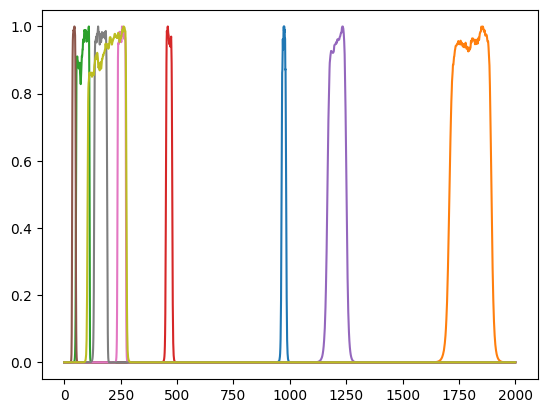

In [38]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(out.shape[0]):
    plt.plot(out[i,400:2400], label=f'Band {i+1}')


### Debug SenpaMAE

In [48]:
from geobreeze.datasets.geobench import GeoBenchDataset
from geobreeze.datasets.base import collate_fn

ds = GeoBenchDataset(
    'm-eurosat',
    split='train',
)


batch = collate_fn([ds[i] for i in range(4)])
batch[0]['gsd'].shape


/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([4, 13])

In [49]:
batch[0]['chn_ids'].shape

torch.Size([4, 13])

In [37]:
import torch
batch = torch.utils.data.default_collate([ds[i] for i in range(4)])

batch[0]['band_ids']

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]])

In [35]:
ds[0][0]['band_ids']

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [23]:
import torch

x = torch.ones((2,3,4))
x[0].shape

torch.Size([3, 4])

In [2]:
import numpy as np
import os

root = '/home/hk-project-pai00028/tum_mhj8661/code/fm-playground/geofm_src/foundation_models/SenPaMAE/responsefunctions'
arr = np.load(os.path.join(root,'rfs_sentinel2_a_13b.npy'))
arr.shape

(2301, 13)

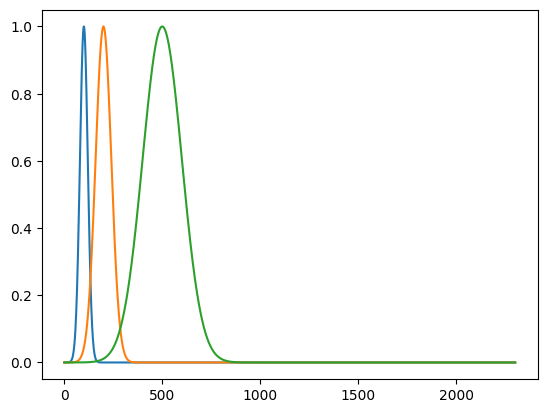

In [28]:
from torch import Tensor
import torch

def _create_srf_from_mu_std(mus: Tensor, sigmas: Tensor):
    assert mus.shape[0] == sigmas.shape[0]
    x_min, x_max = 0, 2301
    x = torch.linspace(x_min, x_max, 2301).unsqueeze(0).to(mus.device)
    vals = torch.exp(-0.5 * ((x - mus.unsqueeze(1)) / sigmas.unsqueeze(1)) ** 2)
    vals = vals / vals.max(dim=1, keepdim=True)[0]
    return vals

vals = _create_srf_from_mu_std(
    torch.tensor([100, 200, 500]),
    torch.tensor([20, 40, 100])
)

vals.shape

import matplotlib.pyplot as plt

plt.figure()
for i in range(vals.shape[0]):
    plt.plot(vals[i,:], label=f'Band {i+1}')


In [27]:
import numpy as np

root = '/home/hk-project-pai00028/tum_mhj8661/code/fm-playground/geofm_src/foundation_models/SenPaMAE/responsefunctions'
p = 'rfs_landsat.npy'
arr = np.load(os.path.join(root,p))
print(arr.shape)
indices = np.argmax(arr, axis=0)
for i in indices:
    print(i)

(2301, 7)
145
209
250
356
559
1333
1955


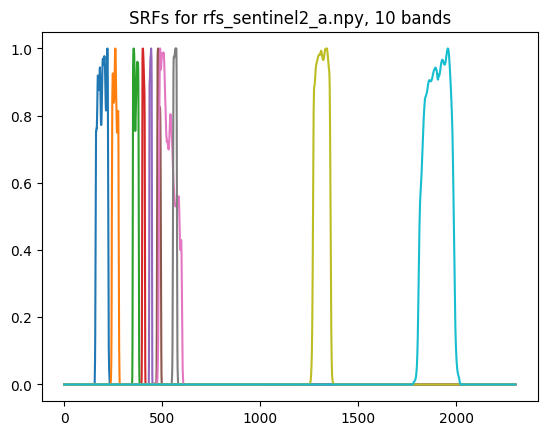

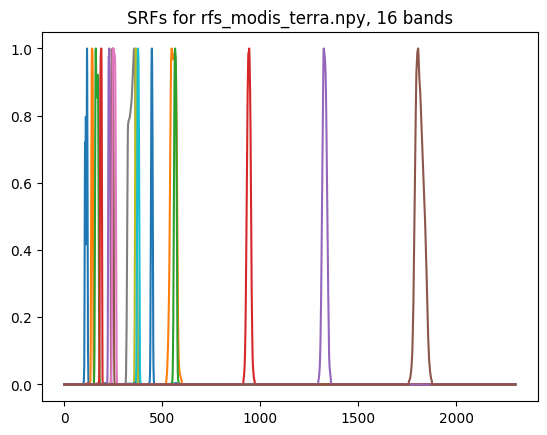

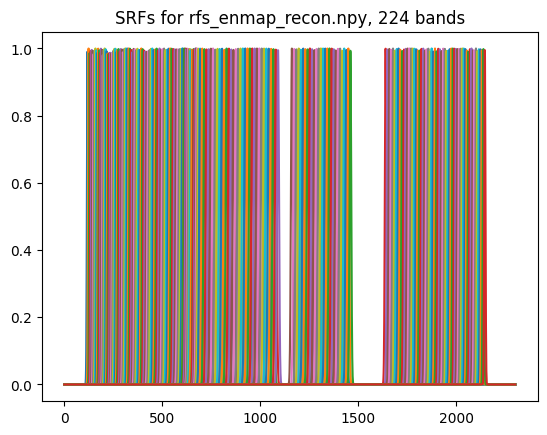

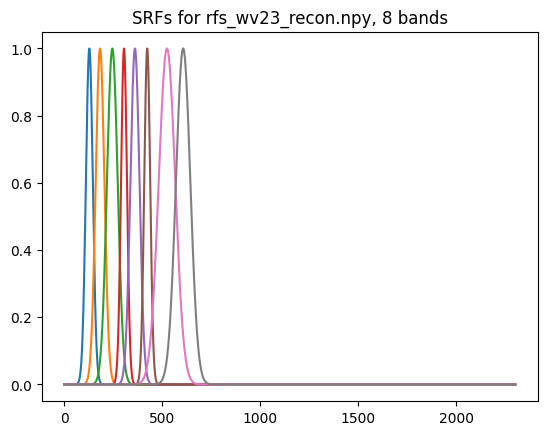

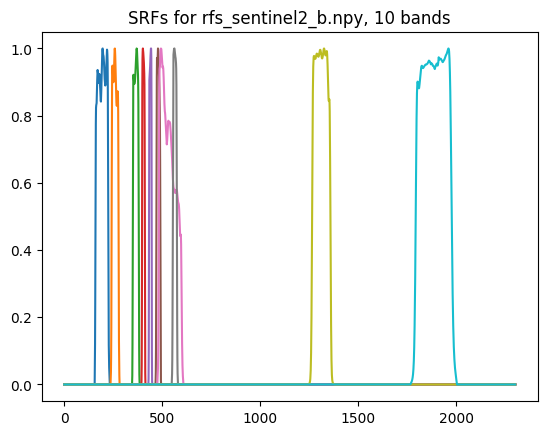

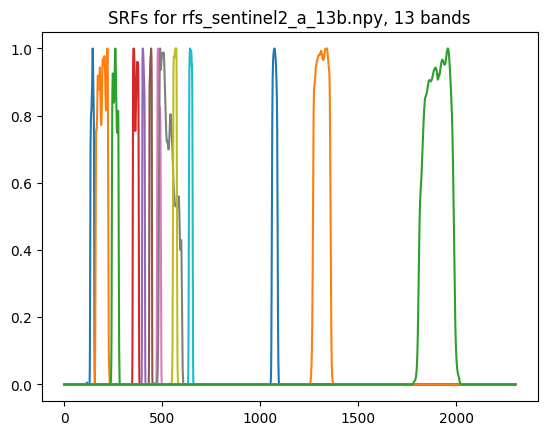

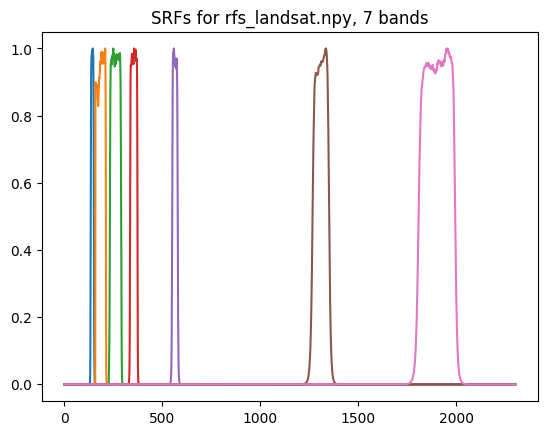

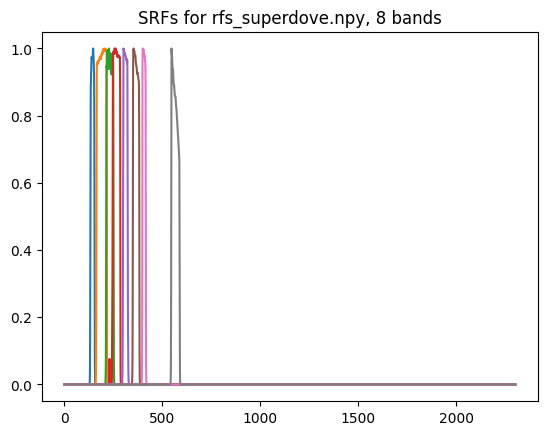

In [6]:
import matplotlib.pyplot as plt

for f in os.listdir(root):
    if not f.endswith('.npy'):
        continue

    arr = np.load(os.path.join(root, f))
    plt.figure()
    for i in range(arr.shape[1]):
        plt.plot(arr[:, i], label=f'Band {i+1}')
    plt.title(f'SRFs for {f}, {arr.shape[1]} bands')

### Cross Sensor

In [5]:
from geobreeze.collect_results import collect_csv

collect_csv('/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/submission')

,metric,val,best_classifier,relpath
0,MulLabAvergPrec_macro,0.583226,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-SD/base/dinov2/bsz=400_e=50
1,MulLabAvergPrec_micro,0.731388,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-SD/base/dinov2/bsz=400_e=50
2,MulLabF1ScoreMacro_macro,0.525878,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-SD/base/dinov2/bsz=400_e=50
3,MulLabF1ScoreMacro_micro,0.660664,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-SD/base/dinov2/bsz=400_e=50
4,MAE,0.394118,blocks_1_pooling_cls_lr_0_00586_1dbn_True,hyperview-SD/base/dinov2/bsz=300_e=50
5,MSE,0.339920,blocks_1_pooling_cls_lr_0_00586_1dbn_True,hyperview-SD/base/dinov2/bsz=300_e=50
6,RMSE,0.583027,blocks_1_pooling_cls_lr_0_00586_1dbn_True,hyperview-SD/base/dinov2/bsz=300_e=50
7,MulLabAvergPrec_macro,0.585021,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-MD/base/dinov2/bsz=400_e=50
8,MulLabAvergPrec_micro,0.732285,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-MD/base/dinov2/bsz=400_e=50
9,MulLabF1ScoreMacro_macro,0.523236,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-MD/base/dinov2/bsz=400_e=50


In [22]:
import os
import pandas as pd
from geobreeze.collect_results import collect_csv

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/xsensor'
collect_csv(p)
df = pd.read_csv(os.path.join(p, 'results.csv')).drop(columns=['Unnamed: 0'])

df['model'] = df['relpath'].apply(lambda x: x.split('/')[2])
df['relpath'] = df['relpath'].apply(lambda x: x.replace('_rgb/','/'))
df['ds'] = df['relpath'].apply(lambda x: x.split('/')[0].split('_')[1])
df['train_ds'] = df['relpath'].apply(lambda x: x.split('/')[0].split('_')[-2])

df['test_ds'] = ''
for i in range(len(df)):
    test_ds_idx = int(df.iloc[i]['metric'].split('_')[-1])
    test_datasets = df.iloc[i]['relpath'].split('/')[0].split('_')[-2:]
    df['test_ds'][i] = test_datasets[test_ds_idx]

df['ds_str'] = df['train_ds'] + '->' + df['test_ds']
df['metric'] = df['metric'].apply(lambda x: x.split('_')[0])
df = df[df['metric'].isin(['acc','MSE'])]
df = df.groupby(['model','ds','ds_str','metric','train_ds','test_ds']).agg({'val': 'max'}).reset_index()
# display(df)

# add normalization
norms = {}
for i in range(len(df)):
    if df.iloc[i]['train_ds'] == df.iloc[i]['test_ds']:
        key = (df.iloc[i]['model'], df.iloc[i]['ds'], df.iloc[i]['train_ds'])
        val = df.iloc[i]['val']
        norms[key] = val

df['base_val'] = pd.Series([norms[model,ds,sens] 
        for model,ds,sens in zip(df['model'],df['ds'], df['train_ds'])])  
df['prc'] = df['val'] / df['base_val']

# everything absolute
# for metric in df['metric'].unique():
#     dfprint = df[df['metric'] == metric]
#     print(metric)
#     dfprint = dfprint.pivot(index='model', columns='ds_str', values='val')
#     display(dfprint)


# only diff
# for metric in df['metric'].unique():
#     print(metric)
#     dfprint = df[df['metric'] == metric]
#     dfprint = dfprint.pivot(index='model', columns='ds_str', values='val')
#     dfprint['MD->SD (prc)'] = dfprint['MD->SD'] / dfprint['MD->MD']
#     dfprint['SD->MD (prc)'] = dfprint['SD->MD'] / dfprint['SD->SD']
#     display(dfprint)


df['ds_str'] = df['ds'] + ':' + df['ds_str']
df = df[df['train_ds'] != df['test_ds']]

dfcls = df[df['metric'] == 'acc']
dfcls['prc'] = round((dfcls['prc']-1.0)*100 , 1)
dfcls = dfcls.pivot(index='model', columns='ds_str', values='prc')
display(dfcls)

dfreg = df[df['metric'] == 'MSE']
dfreg['prc'] = round((dfreg['prc']-1.0)*100 , 1)
dfreg = dfreg.pivot(index='model', columns='ds_str', values='prc')
display(dfreg)

/scratch/ipykernel_2811788/3032963934.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['test_ds'][i] = test_datasets[test_ds_idx]
/scratch/ipykernel_2811788/3032963934.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcls['prc'] = round((dfcls['prc']-1.0)*100 , 1)


ds_str,eurosat:s1->s2,eurosat:s2->s1,so2sat:s1->s2,so2sat:s2->s1
model,,,,
dinov2,NaN,NaN,-73.9,-80.7
dofa,-77.5,-73.3,-63.2,-82.8
panopticon,-50.2,-48.2,-73.8,-86.2


/scratch/ipykernel_2811788/3032963934.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfreg['prc'] = round((dfreg['prc']-1.0)*100 , 1)


ds_str,hypv:MD->SD,hypv:SD->MD
model,,
dinov2,-0.4,0.6
dofa,-2.7,8.8
panopticon,1.0,0.2


### Debug Hyperview

In [7]:
for b in data['bands']:
    print(b)

{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_recon.npy', 'name': 'B001', 'gaussian': {'mu': 418.416, 'sigma': 2.972}, 'id': 'enmap/B001'}
{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_recon.npy', 'name': 'B002', 'gaussian': {'mu': 424.043, 'sigma': 2.831}, 'id': 'enmap/B002'}
{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_recon.npy', 'name': 'B003', 'gaussian': {'mu': 429.457, 'sigma': 2.728}, 'id': 'enmap/B003'}
{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_recon.npy', 'name': 'B004', 'gaussian': {'mu': 434.686, 'sigma': 2.654}, 'id': 'enmap/B004'}
{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_recon.npy', 'name': 'B005', 'gaussian': {'mu': 439.758, 'sigma': 2.605}, 'id': 'enmap/B005'}
{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_r

In [21]:
""" get indices"""
import yaml
import torch
from geobreeze.datasets.utils.utils import load_ds_cfg

sats = {
    'SD': '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/superdove.yaml',
    'MD': '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/modis_terra.yaml',
    'hyperview': '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/intuition.yaml',
    'corine': load_ds_cfg('corine'),
    'SD_rgb': torch.tensor([665.8,565.8,491.0]),
    'MD_rgb': torch.tensor([665.7,554.0,487.1])
}

for k,v in sats.items():
    if isinstance(v, str):
        with open(v, 'r') as f:
            data = yaml.safe_load(f)
        sats[k] = torch.tensor([b['gaussian']['mu'] for b in data['bands'].values()])
    elif isinstance(v, dict):
        data = v
        sats[k] = torch.tensor([b['gaussian']['mu'] for b in data['bands']])
    elif isinstance(v, torch.Tensor):
        pass
    else:
        raise ValueError(f"Unsupported type for {k}: {type(v)}")
    

def find(src, tgt):
    if not isinstance(src, torch.Tensor):
        src = torch.tensor(src)
    if not isinstance(tgt, torch.Tensor):
        tgt = torch.tensor(tgt)
    src = src[:, None]
    tgt = tgt[None, :]
    diff = torch.abs(src - tgt)
    min_diff, min_idx = diff.min(dim=0)
    return min_idx, min_diff

# find(sats['hyperview'], sats['MD'])

# find(sats['hyperview'], [665.69,554,487])
corine_hyperview = {
    'hyperview-sd': find(sats['hyperview'], sats['SD'])[0],
    'hyperview-md': find(sats['hyperview'], sats['MD'])[0],
    'corine-sd': find(sats['corine'], sats['SD'])[0],
    'corine-md': find(sats['corine'], sats['MD'])[0],
}
# find(sats['corine'], sats['SD_rgb'])
# find(sats['corine'], sats['MD_rgb'])

In [22]:
sats

{'SD': tensor([443.7040, 490.9730, 532.7190, 565.8110, 611.5870, 665.7510, 706.9180,
         864.8310]),
 'MD': tensor([ 411.6336,  442.1550,  466.1220,  487.0780,  529.7830,  546.9810,
          554.0260,  644.8980,  665.6950,  677.0680,  746.7360,  857.3230,
          866.5500, 1241.5970, 1627.9720, 2113.1240]),
 'hyperview': tensor([462.0800, 465.2700, 468.4700, 471.6700, 474.8600, 478.0600, 481.2600,
         484.4500, 487.6500, 490.8500, 494.0400, 497.2400, 500.4300, 503.6300,
         506.8300, 510.0300, 513.2200, 516.4200, 519.6100, 522.8100, 526.0100,
         529.2000, 532.4000, 535.6000, 538.7900, 541.9900, 545.1900, 548.3800,
         551.5800, 554.7800, 557.9700, 561.1700, 564.3700, 567.5600, 570.7600,
         573.9600, 577.1500, 580.3500, 583.5500, 586.7400, 589.9400, 593.1400,
         596.3300, 599.5300, 602.7300, 605.9200, 609.1200, 612.3200, 615.5100,
         618.7100, 621.9100, 625.1000, 628.3000, 631.5000, 634.6900, 637.8900,
         641.0900, 644.2800, 647.4800,

In [31]:
from geobreeze.datasets.utils.utils import load_ds_cfg

s2_mus = torch.tensor([b['gaussian']['mu'] for b in load_ds_cfg('m-eurosat')['bands']])

models = {
    'anysat': s2_mus[[1,2,3,4,5,6,7,8,11,12]],
    'croma': s2_mus[[0,1,2,3,4,5,6,7,8,9,11,12]],
    'softcon': s2_mus,
}
datasets = {
    'fmow': load_ds_cfg('FmowDataset'),
    'SD': '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/superdove.yaml',
    'MD': '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/modis_terra.yaml',
    'spacenet': load_ds_cfg('spacenet1_8band'),
}


for sats in [models, datasets]:
    for k,v in sats.items():
        if isinstance(v, str):
            with open(v, 'r') as f:
                data = yaml.safe_load(f)
            sats[k] = torch.tensor([b['gaussian']['mu'] for b in data['bands'].values()])
        elif isinstance(v, dict):
            data = v
            sats[k] = torch.tensor([b['gaussian']['mu'] for b in data['bands']])
        elif isinstance(v, torch.Tensor):
            pass
        else:
            raise ValueError(f"Unsupported type for {k}: {type(v)}")
    

def find(src, tgt):
    if not isinstance(src, torch.Tensor):
        src = torch.tensor(src)
    if not isinstance(tgt, torch.Tensor):
        tgt = torch.tensor(tgt)
    src = src[:, None]
    tgt = tgt[None, :]
    diff = torch.abs(src - tgt)
    min_diff, min_idx = diff.min(dim=0)
    return min_idx, min_diff

for m, m_vals in models.items():
    for d, d_vals in datasets.items():
        min_idx, min_diff = find(d_vals, m_vals)
        
        if d.startswith('SD'):
            for hs, idx in corine_hyperview.items():
                if hs.endswith('-sd'):
                    out_idx = idx[min_idx]
                    print(f"Model {m} to dataset {hs}: {str(out_idx.tolist()).replace(', ',',')}")
        elif d.startswith('MD'):
            for hs, idx in corine_hyperview.items():
                if hs.endswith('-md'):
                    out_idx = idx[min_idx]
                    print(f"Model {m} to dataset {hs}: {str(out_idx.tolist()).replace(', ',',')}")
        else:
            print(f"Model {m} to dataset {d}: {str(min_idx.tolist()).replace(', ',',')}")


Model anysat to dataset fmow: [1,2,4,5,5,6,6,6,7,7]
Model anysat to dataset hyperview-sd: [9,32,64,77,77,77,126,126,126,126]
Model anysat to dataset corine-sd: [15,30,47,53,53,53,74,74,74,74]
Model anysat to dataset hyperview-md: [8,29,64,67,89,89,124,127,149,149]
Model anysat to dataset corine-md: [14,28,47,49,59,59,73,74,135,160]
Model anysat to dataset spacenet: [1,2,4,5,5,6,6,6,7,7]
Model croma to dataset fmow: [0,1,2,4,5,5,6,6,6,7,7,7]
Model croma to dataset hyperview-sd: [0,9,32,64,77,77,77,126,126,126,126,126]
Model croma to dataset corine-sd: [5,15,30,47,53,53,53,74,74,74,74,74]
Model croma to dataset hyperview-md: [0,8,29,64,67,89,89,124,127,127,149,149]
Model croma to dataset corine-md: [4,14,28,47,49,59,59,73,74,74,135,160]
Model croma to dataset spacenet: [0,1,2,4,5,5,6,6,6,7,7,7]
Model softcon to dataset fmow: [0,1,2,4,5,5,6,6,6,7,7,7,7]
Model softcon to dataset hyperview-sd: [0,9,32,64,77,77,77,126,126,126,126,126,126]
Model softcon to dataset corine-sd: [5,15,30,47,53,53

In [19]:
m_vals

tensor([ 492.9971,  559.5988,  664.6301,  704.0059,  740.5521,  782.4191,
         827.5394,  864.7802, 1613.8624, 2203.6182])

In [15]:
corine_hyperview

{'hyperview-sd': tensor([  0,   9,  22,  32,  47,  64,  77, 126]),
 'hyperview-md': tensor([  0,   0,   1,   8,  21,  27,  29,  57,  64,  67,  89, 124, 127, 149,
         149, 149]),
 'corine-sd': tensor([ 5, 15, 23, 30, 38, 47, 53, 74]),
 'corine-md': tensor([  0,   4,  10,  14,  23,  26,  28,  44,  47,  49,  59,  73,  74, 122,
         135, 160])}

In [9]:
out = [b['gaussian']['mu'] for b in load_ds_cfg('m-eurosat')['bands']]
out = torch.tensor(out)
out

tensor([ 442.9226,  492.9971,  559.5988,  664.6301,  704.0059,  740.5521,
         782.4191,  827.5394,  864.7802,  945.0295, 1373.3636, 1613.8624,
        2203.6182])

In [6]:
load_ds_cfg('m-eurosat')

{'ds_name': 'm-eurosat',
 'bands': [{'instrument': 'MSI',
   'level': 'L1C',
   'srf_filename': 'rfs_sentinel2_a_13b.npy',
   'name': '01 - Coastal aerosol',
   'gaussian': {'mu': 442.922568734037, 'sigma': 7.248330717861807},
   'GSD': 60,
   'id': 'sentinel2/B01'},
  {'instrument': 'MSI',
   'level': 'L1C',
   'srf_filename': 'rfs_sentinel2_a_13b.npy',
   'name': '02 - Blue',
   'gaussian': {'mu': 492.9971095687347, 'sigma': 23.810316659477703},
   'GSD': 10,
   'id': 'sentinel2/B02'},
  {'instrument': 'MSI',
   'level': 'L1C',
   'srf_filename': 'rfs_sentinel2_a_13b.npy',
   'name': '03 - Green',
   'gaussian': {'mu': 559.5987534818435, 'sigma': 12.768882177939654},
   'GSD': 10,
   'id': 'sentinel2/B03'},
  {'instrument': 'MSI',
   'level': 'L1C',
   'srf_filename': 'rfs_sentinel2_a_13b.npy',
   'name': '04 - Red',
   'gaussian': {'mu': 664.6300422881802, 'sigma': 11.757355524910432},
   'GSD': 10,
   'id': 'sentinel2/B04'},
  {'instrument': 'MSI',
   'level': 'L1C',
   'srf_filena

In [19]:
from geobreeze.datasets.utils.utils import load_ds_cfg

dsconfig = load_ds_cfg('hyperview')

MD = [1,8,21,27,29,57,64,67,89,124,127]
SD = [9,22,32,47,64,77,126]

SD_rgb = [63, 32,  9]

dsconfig = load_ds_cfg('hyperview')
for i in SD_rgb:
    print(dsconfig['bands'][i]['gaussian']['mu'])



663.46
564.37
490.85


In [ ]:
from torchgeo.datasets import 

In [19]:
from geobreeze.datasets import Hyperview
import os

for split in ['train','val','test']:

    ds = Hyperview(
        root = os.path.expandvars('$DATASETS_DIR/hyperview'),
        split = split,
        do_mask = False,
    )

    print(f"Split: {split}")
    print(f"Number of samples: {len(ds)}")

[HyperviewBenchmark] Building dataset for split: train
Split: train
Number of samples: 1298
[HyperviewBenchmark] Building dataset for split: val
Split: val
Number of samples: 174
[HyperviewBenchmark] Building dataset for split: test
Split: test
Number of samples: 260


In [20]:
OmegaConf.load(p).data.test

[{'_target_': 'Hyperview', 'split': 'test', 'root': '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets//hyperview', 'transform': [{'_target_': 'kornia.augmentation.Resize', 'size': 224, 'keepdim': True}], 'band_ids': [9, 22, 32, 47, 64, 77, 126]}, {'_target_': 'Hyperview', 'split': 'test', 'root': '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets//hyperview', 'transform': [{'_target_': 'kornia.augmentation.Resize', 'size': 224, 'keepdim': True}], 'band_ids': [1, 8, 21, 27, 29, 57, 64, 67, 8, 124, 127]}]

In [11]:
ds

In [ ]:
from geobreeze.factory import 

In [21]:
for xdict,_ in ds:
    print(xdict['imgs'].shape)

pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size([150, 43, 42])
post transform torch.Size([150, 43, 42])
torch.Size([150, 43, 42])
pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size([150, 125, 124])
post transform torch.Size([150, 125, 124])
torch.Size([150, 125, 124])
pre transform torch.Size([150, 42, 42])
post transform torch.Size([150, 42, 42])
torch.Size([150, 42, 42])
pre transform torch.Size([150, 104, 120])
post transform torch.Size([150, 104, 120])
torch.Size([150, 104, 120])
pre transform torch.Size([150, 40, 44])
post transform torch.Size([150, 40, 44])
torch.Size([150, 40, 44])
pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size(

KeyboardInterrupt: 

In [3]:
from omegaconf import OmegaConf
from geobreeze.factory import make_transform_list, make_dataset
from torch.utils.data import DataLoader
import kornia.augmentation as K
import torch

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/xsensor/x_hypv_SD_MD/base/panopticon/bsz=200_e=1/config.yaml'
cfg = OmegaConf.load(p)

trf_list = make_transform_list(cfg.data.train.transform)
trf = K.AugmentationSequential(*trf_list, data_keys=['image'])

img = torch.randn(1, 3, 553, 12)
trf(img).shape

cfg: _target_: <class 'str'>, kornia.augmentation.RandomHorizontalFlip
cfg: p: <class 'float'>, 0.5
cfg: keepdim: <class 'bool'>, True
cfg: _target_: <class 'str'>, kornia.augmentation.RandomVerticalFlip
cfg: p: <class 'float'>, 0.5
cfg: keepdim: <class 'bool'>, True
cfg: _target_: <class 'str'>, kornia.augmentation.RandomResizedCrop
cfg: size: <class 'list'>, [224, 224]
cfg: scale: <class 'list'>, [0.8, 1.0]


TypeError: upsample_bilinear2d() received an invalid combination of arguments - got (Tensor, list, bool, NoneType), but expected one of:
 * (Tensor input, tuple of ints output_size, bool align_corners, tuple of floats scale_factors)
      didn't match because some of the arguments have invalid types: (Tensor, !list of [ListConfig, ListConfig]!, bool, !NoneType!)
 * (Tensor input, tuple of ints output_size, bool align_corners, float scales_h, float scales_w, *, Tensor out)


In [10]:
from omegaconf import OmegaConf
from geobreeze.factory import make_transform_list, make_dataset
from torch.utils.data import DataLoader
import kornia.augmentation as K
import torch

cfg = OmegaConf.create([{
    '_target_': 'RandomResizedCrop',
    'size': (224, 224),
    # 'scale': (0.08, 1.0),
}])

trf_list = make_transform_list(cfg)
trf = K.AugmentationSequential(*trf_list, data_keys=['image'])

img = torch.randn(1, 3, 553, 12)
trf(img).shape

torch.Size([1, 3, 224, 224])

In [8]:
import hydra
import kornia.augmentation as K

cfg = OmegaConf.create([{
    '_target_': 'kornia.augmentation.RandomResizedCrop',
    'size': (224, 224),
    # 'scale': (0.08, 1.0),
}])

cfg = OmegaConf.to_container(cfg, resolve=True)
cfg = cfg[0]

cfg.pop('_target_')
trf = K.RandomResizedCrop(**cfg)

img = torch.randn(1, 3, 553, 12)
trf(img).shape

torch.Size([1, 3, 224, 224])

In [42]:
img = torch.randn(1, 3, 553, 12)

trf(img).shape

TypeError: upsample_bilinear2d() received an invalid combination of arguments - got (Tensor, list, bool, NoneType), but expected one of:
 * (Tensor input, tuple of ints output_size, bool align_corners, tuple of floats scale_factors)
      didn't match because some of the arguments have invalid types: (Tensor, !list of [ListConfig, ListConfig]!, bool, !NoneType!)
 * (Tensor input, tuple of ints output_size, bool align_corners, float scales_h, float scales_w, *, Tensor out)


In [39]:
import torch
import kornia.augmentation as K

trf = K.AugmentationSequential(
    # K.CenterCrop(size=224),
    # K.Resize(size=(224, 224), align_corners=False),
    K.RandomResizedCrop(size=[224,224], scale=[0.08,1.0])
)


img = torch.randn(1, 3, 553, 12)

trf(img).shape

torch.Size([1, 3, 224, 224])

In [16]:
from omegaconf import OmegaConf
from geobreeze.factory import make_dataset
from torch.utils.data import DataLoader

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/xsensor/x_hypv_SD_MD/base/panopticon/bsz=200_e=1/config.yaml'
ds = make_dataset(OmegaConf.load(p).data.train)



dl = DataLoader(
    ds,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

for i, batch in enumerate(dl):
    print(i)
    print(batch['imgs'].shape)
    break

INFO:eval:Subsampled 7/150 bands with ids [9, 22, 32, 47, 64, 77, 126]. Band names are:
  000: B010
  001: B023
  002: B033
  003: B048
  004: B065
  005: B078
  006: B127


{'_target_': 'kornia.augmentation.RandomHorizontalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'kornia.augmentation.RandomVerticalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'kornia.augmentation.Resize', 'size': 224, 'keepdim': True}
[HyperviewBenchmark] Building dataset for split: train
Got subset=100, subsampled dataset to #samples 100 


RuntimeError: stack expects each tensor to be equal size, but got [7, 229, 224] at entry 0 and [7, 224, 224] at entry 1

In [16]:
ds[idx][0]['imgs']

tensor([[[-8.8704e-01, -1.1546e+00, -1.5263e+00,  ...,  4.3612e-01,
           4.2868e-01,  2.8001e-01],
         [-1.0580e+00, -4.4847e-01, -1.5263e+00,  ..., -4.7061e-02,
           5.7008e-02,  2.7258e-01],
         [-9.1678e-01, -3.2210e-01, -1.0134e+00,  ..., -1.3626e-01,
          -1.0653e-01, -1.2140e-01],
         ...,
         [-2.4776e-01, -2.1803e-01, -1.5113e-01,  ...,  4.1382e-01,
           4.9558e-01,  4.5098e-01],
         [-2.5520e-01, -1.9573e-01, -4.7061e-02,  ...,  4.8815e-01,
           6.6655e-01,  7.1115e-01],
         [-2.4033e-01, -2.1060e-01, -2.8493e-01,  ...,  3.7665e-01,
           4.5098e-01,  4.7328e-01]],

        [[-8.2398e-01, -1.1288e+00, -1.4931e+00,  ...,  4.6228e-01,
           3.8793e-01,  3.5075e-01],
         [-1.0173e+00, -4.4479e-01, -1.5006e+00,  ..., -8.7912e-02,
           1.3078e-03,  2.0205e-01],
         [-8.9833e-01, -3.1840e-01, -9.6524e-01,  ..., -1.1022e-01,
          -1.1765e-01, -1.3252e-01],
         ...,
         [-2.7379e-01, -2

In [13]:
for idx in range(100):
    print(ds[idx][0]['imgs'].shape)

torch.Size([150, 11, 11])
torch.Size([150, 43, 42])
torch.Size([150, 11, 11])
torch.Size([150, 125, 124])
torch.Size([150, 42, 42])
torch.Size([150, 104, 120])
torch.Size([150, 40, 44])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 125, 136])
torch.Size([150, 11, 11])
torch.Size([150, 108, 92])
torch.Size([150, 11, 11])
torch.Size([150, 46, 47])
torch.Size([150, 11, 11])
torch.Size([150, 124, 123])
torch.Size([150, 11, 11])
torch.Size([150, 126, 125])
torch.Size([150, 43, 42])
torch.Size([150, 117, 119])
torch.Size([150, 25, 71])
torch.Size([150, 11, 11])
torch.Size([150, 30, 42])
torch.Size([150, 184, 110])
torch.Size([150, 148, 125])
torch.Size([150, 35, 38])
torch.Size([150, 11, 11])
torch.Size([150, 46, 48])
torch.Size([150, 43, 42])
torch.Size([150, 70, 129])
torch.Size([150, 42, 42])
torch.Size([150, 11, 11])
torch.Size([150, 111, 110])
torch.Size([150, 46, 48])
torch.Size([150, 1

In [9]:
ds.dataset.df['file_paths'].apply(lambda x: x.split('/')[-3:])

0       [hyperview, train_data, 364.npz]
1       [hyperview, train_data, 945.npz]
2       [hyperview, train_data, 596.npz]
3      [hyperview, train_data, 1353.npz]
4       [hyperview, train_data, 955.npz]
                     ...                
255    [hyperview, train_data, 1258.npz]
256     [hyperview, train_data, 284.npz]
257    [hyperview, train_data, 1360.npz]
258    [hyperview, train_data, 1135.npz]
259    [hyperview, train_data, 1322.npz]
Name: file_paths, Length: 260, dtype: object

### Create large eval table 

In [23]:
import pandas as pd

def get_alldf():
    p = '/home/hk-project-pai00028/tum_mhj8661/code/table2.csv'
    table2_df = pd.read_csv(p)
    table2_df = table2_df[['benv2-s2','benv2-s1','RESISC45']]

    # p = '/home/hk-project-pai00028/tum_mhj8661/code/table_generalization.csv'
    p = '/home/hk-project-pai00028/tum_mhj8661/code/table_generalization_v2_corine_corrected.csv'
    generalization_df = pd.read_csv(p)
    generalization_df = generalization_df.drop(index=['DINOv2-PE','Croma-PE','Softcon-PE','Anysat-PE',])
    display(generalization_df)

    p = '/home/hk-project-pai00028/tum_mhj8661/code/gb_cls.csv'
    gb_cls = pd.read_csv(p)
    gb_cls.drop(columns=['benv2-s2'], inplace=True)
    gb_cls.rename(columns={'m-pv4ger': 'm-pv4ger-cls'}, inplace=True)

    p = '/home/hk-project-pai00028/tum_mhj8661/code/gb_segm.csv'
    gb_segm = pd.read_csv(p)
    gb_segm.rename(columns={'m-pv4ger': 'm-pv4ger-seg'}, inplace=True)

    return pd.concat([table2_df, generalization_df, gb_cls, gb_segm], axis=1)

all_df = get_alldf()
all_df

,SpaceNet1,FMoW,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC,DT
SenPaMAE,86.2,16.9,59.5,60.1,0.366,0.355,NaN,NaN
DOFA,89.9,42.0,81.0,80.2,0.334,0.338,0.385,1.032
Panopticon,90.3,50.3,85.8,86.2,0.313,0.321,0.315,0.963


,benv2-s2,benv2-s1,RESISC45,SpaceNet1,FMoW,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC,...,m-eurosat,m-forestnet,m-pv4ger-cls,m-so2sat,m-cashew,m-chesapeake,m-neontree,m-nzcattle,m-pv4ger-seg,m-sacrop
DINOv2,80.1,NaN,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.5,53.5,97.5,60.8,65.9,78.5,80.9,92.7,96.9,51.2
CROMA,79.4,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,91.1,NaN,NaN,53.5,44.3,NaN,NaN,NaN,NaN,48.4
SoftCon,84.3,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92.2,NaN,NaN,52.1,54.5,NaN,NaN,NaN,NaN,51.3
AnySat,76.8,64.4,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87.6,50.9,92.8,42.5,38.8,75.9,79.6,92.5,92.2,39.5
Galileo,76.5,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.6,NaN,NaN,54.2,40.4,NaN,NaN,NaN,NaN,39.5
SenPaMAE,63.8,NaN,28.2,86.2,16.9,59.5,60.1,0.366,0.355,NaN,...,77.5,33.5,87.1,33.7,40.7,59.9,79.5,89.5,78.3,39.3
DOFA,78.8,72.0,92.0,89.9,42.0,81.0,80.2,0.334,0.338,0.385,...,92.9,53.2,97.4,54.2,56.4,78.2,80.4,92.8,96.3,51.3
Panopticon,83.9,78.4,90.9,90.3,50.3,85.8,86.2,0.313,0.321,0.315,...,96.4,56.3,96.4,61.7,59.3,78.1,79.6,92.6,95.2,52.6


In [24]:
""" get new results """
import os
import pandas as pd
from geobreeze.collect_results import collect_csv

cls_dir = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/fmplayground/t1_v3/'
collect_csv(cls_dir)

def map_dsname(name: str):
    if 'benv2' in name:
        name = name.replace('rgb','s2')
        return '_'.join(name.split('_')[:2])
    elif 'corine' in name:
        return name
    elif 'geobench' in name:
        name = name.removeprefix('geobench_')
        name = name.replace('brick_kiln','brickkiln')

    return name.split('_')[0]

def map_modelname(name: str):
    name = name.split('_')[0]
    name_to_papername = {
        'dinov2': 'DINOv2',
        'croma': 'CROMA',
        'softcon': 'SoftCon',
        'dofa': 'DOFA',
        'panopticon': 'Panopticon',
        'galileo': 'Galileo',
        'senpamae': 'SenPaMAE',
        'anysat': 'Anysat',
    }
    return name_to_papername[name]

def get_newdf():
    p = os.path.join(cls_dir, 'results.csv')
    df = pd.read_csv(p).drop(columns=['Unnamed: 0'])
    df['_ds'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['_model'] = df['relpath'].apply(lambda x: x.split('/')[2])
    df = df[ ~ df['_model'].isin(['panopticon_chnsim','panopticon_v2','panopticon_v4']) ]
    df['ds'] = df['_ds'].apply(lambda x: map_dsname(x))
    df['model'] = df['_model'].apply(lambda x: map_modelname(x))
    df = df[ df['metric'].isin(['acc_top-1_micro','MulLabAvergPrec_micro'])]

    df = df.groupby(['model','ds']).agg({'val': 'max'}).reset_index()

    df = df.pivot(index='model', columns='ds', values='val')
    df = round(df*100, 1)
    index_order = ['DINOv2', 'CROMA', 'SoftCon', 'AnySat', 'Galileo', 'SenPaMAE', 'DOFA',
        'Panopticon']
    return df.reindex(index_order)

newdf = get_newdf()
newdf

ds,benv2_s1,benv2_s2,brickkiln,eurosat,eurosat-sar,fmow,forestnet,m-so2sat-s1,pv4ger,resisc45,so2sat
model,,,,,,,,,,,
DINOv2,NaN,80.1,97.5,95.5,95.3,47.0,53.5,30.0,97.5,94.0,60.8
CROMA,74.5,79.4,94.5,91.1,85.6,NaN,NaN,27.6,NaN,NaN,53.5
SoftCon,80.0,84.3,94.9,92.2,88.4,NaN,NaN,28.5,NaN,NaN,52.1
AnySat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Galileo,70.3,76.5,93.1,88.6,NaN,NaN,NaN,NaN,NaN,NaN,54.2
SenPaMAE,NaN,63.8,83.9,77.5,NaN,16.9,33.5,NaN,87.1,28.2,33.7
DOFA,72.0,78.8,95.8,92.9,89.1,42.0,53.2,26.8,97.4,92.0,54.2
Panopticon,78.4,83.9,96.7,96.4,97.0,50.3,56.3,32.2,96.4,90.9,61.7


In [28]:
""" build table """
import yaml 

def merge(cols=['m-so2sat-s1', 'eurosat-sar']):
    all_df = get_alldf()
    new_df = get_newdf()
    new_results = new_df[cols]
    print(all_df.shape)
    print(new_results.shape)

    out = pd.concat([all_df, new_results], axis=1)
    print(out.shape)
    return out

all_df = merge()

new_vals = {
    'DINOv2': {
        'Corine-SD': 80.6,
        'Corine-MD': 80.7,
        'Hyperview-MD': 0.335,
        'Hyperview-SD': 0.340,
        'SpaceNet1': 90.5,
        'FMoW': 47.0,   
        'benv2-s1': 73.8,
    },
    'AnySat': {
        'eurosat-sar': 73.3,
        'm-so2sat-s1': 24.5,
    }
}

for m, m_vals in new_vals.items():
    for k, v in m_vals.items():
        all_df.loc[m, k] = v

p = '/home/hk-project-pai00028/tum_mhj8661/code/tasks.yaml'
with open(p) as f:
    ds_to_tasks = yaml.safe_load(f)

# add cross terms
cross_terms = ds_to_tasks.pop('_cross_terms', {})
for ds, ids in ds_to_tasks.items():
    for item in cross_terms:
        assert len(item.keys()) == 1
        assert len(item.values()) == 1 
        c_name = list(item.keys())[0]
        c_ids = list(item.values())[0]
        if all([c in ids for c in c_ids]):
            ds_to_tasks[ds].append(c_name)

# process
group_ids = set()
for groups in ds_to_tasks.values():
    for id in groups:
        group_ids.add(id)

df = pd.DataFrame(index=all_df.index)
for id in group_ids:
    agg = []
    print('GROUP ', id)
    for ds, groups in ds_to_tasks.items():
        if id in groups and ds in all_df.columns:
            print('  ', ds)
            agg.append(all_df[ds])
    agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
    df[id] = agg

printdf = df[['all','all_linprobe','all_segm','linprob_s2','linprob_s1','linprob_rgb','segm_s2','segm_rgb','rgb','s2','s1']]
display(printdf)

printdf = df[['all','all_linprobe','all_segm','rgb','s2','s1','others']]
display(printdf)

printdf.columns = [c.replace('_','-') for c in printdf.columns]
printout = printdf.round(1).style.format(precision=1).highlight_max(axis=0, props='textbf:--rwrap;').to_latex()
printout = printout.replace('nan', '-')
print(printout)

,SpaceNet1,FMoW,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC,DT
SenPaMAE,86.2,16.9,59.5,60.1,0.366,0.355,NaN,NaN
DOFA,89.9,42.0,81.0,80.2,0.334,0.338,0.385,1.032
Panopticon,90.3,50.3,85.8,86.2,0.313,0.321,0.315,0.963


(8, 22)
(8, 2)
(8, 24)
GROUP  wv8
   FMoW
GROUP  s2
   benv2-s2
   m-brick-kiln
   m-eurosat
   m-so2sat
   m-cashew
   m-sacrop
GROUP  wv7
   SpaceNet1
GROUP  gb_segm
   m-cashew
   m-chesapeake
   m-neontree
   m-nzcattle
   m-pv4ger-seg
   m-sacrop
GROUP  all_linprobe
   benv2-s2
   benv2-s1
   RESISC45
   SpaceNet1
   FMoW
   Corine-SD
   Corine-MD
   m-brick-kiln
   m-eurosat
   m-forestnet
   m-pv4ger-cls
   m-so2sat
   m-so2sat-s1
   eurosat-sar
GROUP  RGB
   m-pv4ger-cls
GROUP  rgbn
   m-chesapeake
GROUP  SD
   Corine-SD
   Hyperview-SD
GROUP  GOES16
   TC
GROUP  linprob_s1
   benv2-s1
   m-so2sat-s1
   eurosat-sar
GROUP  segm_s2
   m-cashew
   m-sacrop
GROUP  Himawari
   DT
GROUP  linprob_rgb
   RESISC45
GROUP  bench
   benv2-s2
   benv2-s1
   RESISC45
   SpaceNet1
   FMoW
   m-brick-kiln
   m-eurosat
   m-forestnet
   m-pv4ger-cls
   m-so2sat
   m-cashew
   m-chesapeake
   m-neontree
   m-nzcattle
   m-pv4ger-seg
   m-sacrop
GROUP  segm_rgb
   m-neontree
   m-nzcattle
   m-pv

/scratch/ipykernel_583408/3748329055.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
/scratch/ipykernel_583408/3748329055.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
/scratch/ipykernel_583408/3748329055.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
/scratch/ipykernel_583

,all,all_linprobe,all_segm,linprob_s2,linprob_s1,linprob_rgb,segm_s2,segm_rgb,rgb,s2,s1
DINOv2,78.7,79.2,77.7,83.5,66.4,94.0,58.6,90.2,91.1,75.2,66.4
CROMA,NaN,NaN,NaN,79.6,61.2,NaN,46.3,NaN,NaN,68.5,61.2
SoftCon,NaN,NaN,NaN,80.9,65.6,NaN,52.9,NaN,NaN,71.6,65.6
AnySat,NaN,NaN,69.8,74.0,54.1,65.5,39.2,88.1,82.4,62.4,54.1
Galileo,NaN,NaN,NaN,78.1,NaN,NaN,40.0,NaN,NaN,65.4,NaN
SenPaMAE,NaN,NaN,64.5,64.7,NaN,28.2,40.0,82.4,68.9,56.5,NaN
DOFA,76.8,77.2,75.9,80.4,62.6,92.0,53.8,89.8,90.4,71.6,62.6
Panopticon,79.5,80.9,76.2,84.7,69.2,90.9,56.0,89.1,89.6,75.1,69.2


,all,all_linprobe,all_segm,rgb,s2,s1,others
DINOv2,78.7,79.2,77.7,91.1,75.2,66.4,83.9
CROMA,NaN,NaN,NaN,NaN,68.5,61.2,NaN
SoftCon,NaN,NaN,NaN,NaN,71.6,65.6,NaN
AnySat,NaN,NaN,69.8,82.4,62.4,54.1,NaN
Galileo,NaN,NaN,NaN,NaN,65.4,NaN,NaN
SenPaMAE,NaN,NaN,64.5,68.9,56.5,NaN,68.6
DOFA,76.8,77.2,75.9,90.4,71.6,62.6,83.7
Panopticon,79.5,80.9,76.2,89.6,75.1,69.2,87.4


\begin{tabular}{lrrrrrrr}
 & all & all-linprobe & all-segm & rgb & s2 & s1 & others \\
DINOv2 & 78.7 & 79.2 & \textbf{77.7} & \textbf{91.1} & \textbf{75.2} & 66.4 & 83.9 \\
CROMA & - & - & - & - & 68.5 & 61.2 & - \\
SoftCon & - & - & - & - & 71.6 & 65.6 & - \\
AnySat & - & - & 69.8 & 82.4 & 62.4 & 54.1 & - \\
Galileo & - & - & - & - & 65.4 & - & - \\
SenPaMAE & - & - & 64.5 & 68.9 & 56.5 & - & 68.6 \\
DOFA & 76.8 & 77.2 & 75.9 & 90.4 & 71.6 & 62.6 & 83.7 \\
Panopticon & \textbf{79.5} & \textbf{80.9} & 76.2 & 89.6 & 75.1 & \textbf{69.2} & \textbf{87.4} \\
\end{tabular}



In [29]:
all_df

,benv2-s2,benv2-s1,RESISC45,SpaceNet1,FMoW,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC,...,m-pv4ger-cls,m-so2sat,m-cashew,m-chesapeake,m-neontree,m-nzcattle,m-pv4ger-seg,m-sacrop,m-so2sat-s1,eurosat-sar
DINOv2,80.1,73.8,94.0,90.5,47.0,80.6,80.7,0.340,0.335,NaN,...,97.5,60.8,65.9,78.5,80.9,92.7,96.9,51.2,30.0,95.3
CROMA,79.4,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,53.5,44.3,NaN,NaN,NaN,NaN,48.4,27.6,85.6
SoftCon,84.3,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,52.1,54.5,NaN,NaN,NaN,NaN,51.3,28.5,88.4
AnySat,76.8,64.4,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92.8,42.5,38.8,75.9,79.6,92.5,92.2,39.5,24.5,73.3
Galileo,76.5,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,54.2,40.4,NaN,NaN,NaN,NaN,39.5,NaN,NaN
SenPaMAE,63.8,NaN,28.2,86.2,16.9,59.5,60.1,0.366,0.355,NaN,...,87.1,33.7,40.7,59.9,79.5,89.5,78.3,39.3,NaN,NaN
DOFA,78.8,72.0,92.0,89.9,42.0,81.0,80.2,0.334,0.338,0.385,...,97.4,54.2,56.4,78.2,80.4,92.8,96.3,51.3,26.8,89.1
Panopticon,83.9,78.4,90.9,90.3,50.3,85.8,86.2,0.313,0.321,0.315,...,96.4,61.7,59.3,78.1,79.6,92.6,95.2,52.6,32.2,97.0


In [25]:
df_to_print['FMoW'] = df_to_print['FMoW'].astype(float)

df_to_print.dtypes

benv2-s2        float64
benv2-s1        float64
RESISC45        float64
SpaceNet1       float64
FMoW            float64
Corine-SD       float64
Corine-MD       float64
Hyperview-SD    float64
Hyperview-MD    float64
TC              float64
DT              float64
m-brick-kiln    float64
m-eurosat       float64
m-forestnet     float64
m-pv4ger-cls    float64
m-so2sat        float64
m-cashew        float64
m-chesapeake    float64
m-neontree      float64
m-nzcattle      float64
m-pv4ger-seg    float64
m-sacrop        float64
m-so2sat-s1     float64
eurosat-sar     float64
dtype: object

In [31]:
with pd.option_context('display.max_columns', None):
    display(df)

,s1,wv8,RGB,all_linprobe,gb_segm,MD,gb_cls,rgb,all_segm,bench,SD,l8,s2,GOES16,Himawari,segm_rgb,rgbn,linprob_s2,segm_s2,linprob_s1,all,others,wv7,linprob_rgb
DINOv2,66.4,47.0,97.5,79.2,77.7,40.5,76.8,91.1,77.7,80.6,40.5,53.5,75.2,NaN,NaN,90.2,78.5,83.5,58.6,66.4,78.7,83.9,90.5,94.0
CROMA,61.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.5,NaN,NaN,NaN,NaN,79.6,46.3,61.2,NaN,NaN,NaN,NaN
SoftCon,65.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.6,NaN,NaN,NaN,NaN,80.9,52.9,65.6,NaN,NaN,NaN,NaN
AnySat,NaN,NaN,92.8,NaN,69.8,NaN,67.6,82.4,69.8,NaN,NaN,50.9,62.4,NaN,NaN,88.1,75.9,74.0,39.2,NaN,NaN,NaN,NaN,65.5
Galileo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.4,NaN,NaN,NaN,NaN,78.1,40.0,NaN,NaN,NaN,NaN,NaN
SenPaMAE,NaN,16.9,87.1,NaN,64.5,30.2,57.2,68.9,64.5,NaN,29.9,33.5,56.5,NaN,NaN,82.4,59.9,64.7,40.0,NaN,NaN,68.6,86.2,28.2
DOFA,62.6,42.0,97.4,77.2,75.9,40.3,74.0,90.4,75.9,78.8,40.7,53.2,71.6,0.4,1.0,89.8,78.2,80.4,53.8,62.6,76.8,83.7,89.9,92.0
Panopticon,69.2,50.3,96.4,80.9,76.2,43.3,77.8,89.6,76.2,80.6,43.1,56.3,75.1,0.3,1.0,89.1,78.1,84.7,56.0,69.2,79.5,87.4,90.3,90.9


In [33]:
df[['s1','rgb','s2','gb_segm','gb_cls','all','all_segm','all_linprobe','segm_s2','segm_rgb']]

,s1,rgb,s2,gb_segm,gb_cls,all,all_segm,all_linprobe,segm_s2,segm_rgb
DINOv2,66.4,91.1,75.2,77.7,76.8,78.7,77.7,79.2,58.6,90.2
CROMA,61.2,NaN,68.5,NaN,NaN,NaN,NaN,NaN,46.3,NaN
SoftCon,65.6,NaN,71.6,NaN,NaN,NaN,NaN,NaN,52.9,NaN
AnySat,NaN,82.4,62.4,69.8,67.6,NaN,69.8,NaN,39.2,88.1
Galileo,NaN,NaN,65.4,NaN,NaN,NaN,NaN,NaN,40.0,NaN
SenPaMAE,NaN,68.9,56.5,64.5,57.2,NaN,64.5,NaN,40.0,82.4
DOFA,62.6,90.4,71.6,75.9,74.0,76.8,75.9,77.2,53.8,89.8
Panopticon,69.2,89.6,75.1,76.2,77.8,79.5,76.2,80.9,56.0,89.1


In [32]:
df.columns

Index(['s1', 'wv8', 'RGB', 'all_linprobe', 'gb_segm', 'MD', 'gb_cls', 'rgb',
       'all_segm', 'bench', 'SD', 'l8', 's2', 'GOES16', 'Himawari', 'segm_rgb',
       'rgbn', 'linprob_s2', 'segm_s2', 'linprob_s1', 'all', 'others', 'wv7',
       'linprob_rgb'],
      dtype='object')

In [35]:
all_df

,benv2-s2,benv2-s1,RESISC45,SpaceNet1,FMoW,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC,...,m-pv4ger-cls,m-so2sat,m-cashew,m-chesapeake,m-neontree,m-nzcattle,m-pv4ger-seg,m-sacrop,m-so2sat-s1,eurosat-sar
DINOv2,80.1,73.8,94.0,90.5,47.0,80.6,80.7,0.340,0.335,NaN,...,97.5,60.8,65.9,78.5,80.9,92.7,96.9,51.2,30.0,95.3
CROMA,79.4,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,53.5,44.3,NaN,NaN,NaN,NaN,48.4,27.6,85.6
SoftCon,84.3,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,52.1,54.5,NaN,NaN,NaN,NaN,51.3,28.5,88.4
AnySat,76.8,64.4,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92.8,42.5,38.8,75.9,79.6,92.5,92.2,39.5,NaN,NaN
Galileo,76.5,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,54.2,40.4,NaN,NaN,NaN,NaN,39.5,NaN,NaN
SenPaMAE,63.8,NaN,28.2,86.2,16.9,59.5,60.1,0.366,0.355,NaN,...,87.1,33.7,40.7,59.9,79.5,89.5,78.3,39.3,NaN,NaN
DOFA,78.8,72.0,92.0,89.9,42.0,81.0,80.2,0.334,0.338,0.385,...,97.4,54.2,56.4,78.2,80.4,92.8,96.3,51.3,26.8,89.1
Panopticon,83.9,78.4,90.9,90.3,50.3,85.8,86.2,0.313,0.321,0.315,...,96.4,61.7,59.3,78.1,79.6,92.6,95.2,52.6,32.2,97.0


In [41]:
from copy import deepcopy

all_df['FMoW'] = all_df['FMoW'].astype(float)
df_to_print = all_df

df_to_print = deepcopy(df_to_print)
df_to_print.columns = [c.replace('_','-') for c in df_to_print.columns]
df_to_print = df_to_print.transpose()

# Apply different precision formatting
def format_func(x):
    if x < 1.0:
        return '{:.3f}'.format(x)
    return '{:.1f}'.format(x)

printout = df_to_print.style.format(format_func).highlight_max(axis=1, props='textbf:--rwrap;').to_latex()
printout = printout.replace('nan', '-')
print(printout)

\begin{tabular}{lrrrrrrrr}
 & DINOv2 & CROMA & SoftCon & AnySat & Galileo & SenPaMAE & DOFA & Panopticon \\
benv2-s2 & 80.1 & 79.4 & \textbf{84.3} & 76.8 & 76.5 & 63.8 & 78.8 & 83.9 \\
benv2-s1 & 73.8 & 70.3 & \textbf{80.0} & 64.4 & 70.3 & - & 72.0 & 78.4 \\
RESISC45 & \textbf{94.0} & - & - & 65.5 & - & 28.2 & 92.0 & 90.9 \\
SpaceNet1 & \textbf{90.5} & - & - & - & - & 86.2 & 89.9 & 90.3 \\
FMoW & 47.0 & - & - & - & - & 16.9 & 42.0 & \textbf{50.3} \\
Corine-SD & 80.6 & - & - & - & - & 59.5 & 81.0 & \textbf{85.8} \\
Corine-MD & 80.7 & - & - & - & - & 60.1 & 80.2 & \textbf{86.2} \\
Hyperview-SD & 0.340 & - & - & - & - & \textbf{0.366} & 0.334 & 0.313 \\
Hyperview-MD & 0.335 & - & - & - & - & \textbf{0.355} & 0.338 & 0.321 \\
TC & - & - & - & - & - & - & \textbf{0.385} & 0.315 \\
DT & - & - & - & - & - & - & \textbf{1.0} & 0.963 \\
m-brick-kiln & \textbf{97.5} & 94.5 & 94.9 & 89.3 & 93.1 & 83.9 & 95.8 & 96.7 \\
m-eurosat & 95.5 & 91.1 & 92.2 & 87.6 & 88.6 & 77.5 & 92.9 & \textbf{96.4} \\
m

In [36]:
pd.set_option('display.max_columns', None)
display(all_df)

,benv2-s2,benv2-s1,RESISC45,SpaceNet1,FMoW,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC,DT,m-brick-kiln,m-eurosat,m-forestnet,m-pv4ger-cls,m-so2sat,m-cashew,m-chesapeake,m-neontree,m-nzcattle,m-pv4ger-seg,m-sacrop,m-so2sat-s1,eurosat-sar
DINOv2,80.1,73.8,94.0,90.5,47.0,80.6,80.7,0.340,0.335,NaN,NaN,97.5,95.5,53.5,97.5,60.8,65.9,78.5,80.9,92.7,96.9,51.2,30.0,95.3
CROMA,79.4,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.5,91.1,NaN,NaN,53.5,44.3,NaN,NaN,NaN,NaN,48.4,27.6,85.6
SoftCon,84.3,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.9,92.2,NaN,NaN,52.1,54.5,NaN,NaN,NaN,NaN,51.3,28.5,88.4
AnySat,76.8,64.4,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.3,87.6,50.9,92.8,42.5,38.8,75.9,79.6,92.5,92.2,39.5,NaN,NaN
Galileo,76.5,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.1,88.6,NaN,NaN,54.2,40.4,NaN,NaN,NaN,NaN,39.5,NaN,NaN
SenPaMAE,63.8,NaN,28.2,86.2,16.9,59.5,60.1,0.366,0.355,NaN,NaN,83.9,77.5,33.5,87.1,33.7,40.7,59.9,79.5,89.5,78.3,39.3,NaN,NaN
DOFA,78.8,72.0,92.0,89.9,42.0,81.0,80.2,0.334,0.338,0.385,1.032,95.8,92.9,53.2,97.4,54.2,56.4,78.2,80.4,92.8,96.3,51.3,26.8,89.1
Panopticon,83.9,78.4,90.9,90.3,50.3,85.8,86.2,0.313,0.321,0.315,0.963,96.7,96.4,56.3,96.4,61.7,59.3,78.1,79.6,92.6,95.2,52.6,32.2,97.0


In [70]:
print(alldf.shape)
alldf.columns

(8, 24)


Index(['benv2-s2', 'benv2-s1', 'RESISC45', 'SpaceNet1', 'FMoW', 'Corine-SD',
       'Corine-MD', 'Hyperview-SD', 'Hyperview-MD', 'TC', 'DT', 'm-brick-kiln',
       'm-eurosat', 'm-forestnet', 'm-pv4ger-cls', 'm-so2sat', 'm-cashew',
       'm-chesapeake', 'm-neontree', 'm-nzcattle', 'm-pv4ger-seg', 'm-sacrop',
       'm-so2sat-s1', 'eurosat-sar'],
      dtype='object')

In [6]:
all_df['RESISC45']

DINOv2        94.0
CROMA          NaN
SoftCon        NaN
AnySat        65.5
Galileo        NaN
SenPaMAE      28.2
DOFA          92.0
Panopticon    90.9
Name: RESISC45, dtype: float64

\begin{tabular}{lrrrrrrr}
 & all & all-linprobe & all-segm & rgb & s2 & s1 & others \\
DINOv2 & nan & nan & \textbf{77.7} & \textbf{91.1} & \textbf{75.2} & nan & nan \\
CROMA & nan & nan & nan & nan & 68.5 & 70.3 & nan \\
SoftCon & nan & nan & nan & nan & 71.6 & \textbf{80.0} & nan \\
AnySat & nan & nan & 69.8 & 82.4 & 62.4 & 64.4 & nan \\
Galileo & nan & nan & nan & nan & 65.4 & 70.3 & nan \\
SenPaMAE & nan & nan & 64.5 & 68.9 & 56.5 & nan & 68.6 \\
DOFA & 76.3 & 77.8 & 75.9 & 90.4 & 71.6 & 72.0 & 73.2 \\
Panopticon & \textbf{80.6} & \textbf{83.9} & 76.2 & 89.6 & 75.1 & 78.4 & \textbf{87.4} \\
\end{tabular}



In [30]:
df = pd.read_csv('/home/hk-project-pai00028/tum_mhj8661/code/thesis - Sheet6.csv')
df.index = range(1, len(df)+1)
df = df[['name','source','sensor','#nchns','task','#classes']]
display(df)
print(df.to_latex())

,name,source,sensor,#nchns,task,#classes
1,RESISC45,NaN,RGB,3,cls,45
2,m-pv4ger-cls,NaN,RGB,3,cls,2
3,m-chesapeake,NaN,RGBN,4,segm,4
4,m-neontree,NaN,RGB,3,segm,2
5,m-nzcattle,NaN,RGB,3,segm,2
6,m-pv4ger-seg,NaN,RGB,3,segm,2
7,benv2-s2,BigEarthNet-v2,S2,13,cls,19
8,m-sacrop,NaN,S2,13,segm,10
9,m-so2sat-s2,NaN,S2,10,cls,17
10,m-cashew,NaN,S2,13,segm,7


\begin{tabular}{llllrlr}
\toprule
{} &          name &          source &     sensor &  \#nchns &  task &  \#classes \\
\midrule
1  &      RESISC45 &             NaN &        RGB &       3 &   cls &        45 \\
2  &  m-pv4ger-cls &             NaN &        RGB &       3 &   cls &         2 \\
3  &  m-chesapeake &             NaN &       RGBN &       4 &  segm &         4 \\
4  &    m-neontree &             NaN &        RGB &       3 &  segm &         2 \\
5  &    m-nzcattle &             NaN &        RGB &       3 &  segm &         2 \\
6  &  m-pv4ger-seg &             NaN &        RGB &       3 &  segm &         2 \\
7  &      benv2-s2 &  BigEarthNet-v2 &         S2 &      13 &   cls &        19 \\
8  &      m-sacrop &             NaN &         S2 &      13 &  segm &        10 \\
9  &   m-so2sat-s2 &             NaN &         S2 &      10 &   cls &        17 \\
10 &      m-cashew &             NaN &         S2 &      13 &  segm &         7 \\
11 &  m-brick-kiln &        GeoBench &    

/scratch/ipykernel_2864705/3485080676.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


### Debug datasets

0.16


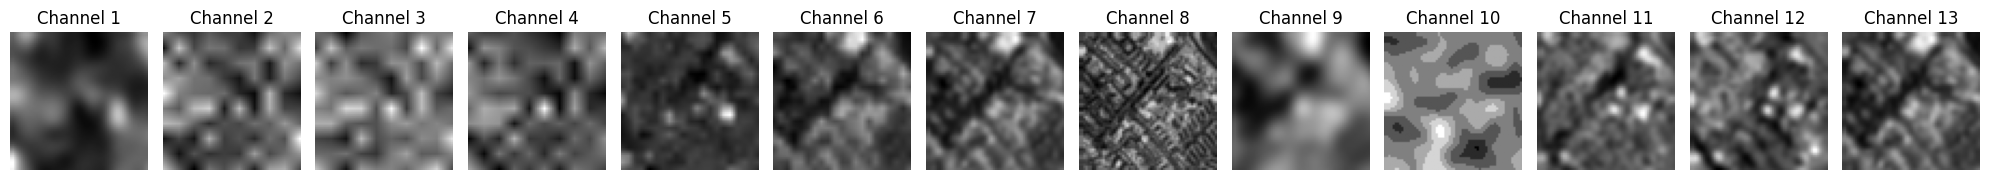

In [13]:
from geobreeze.datasets import GeoBenchDataset
from geobreeze.datasets.utils.augmentations import DownUpSample
from omegaconf import OmegaConf
from geobreeze.factory import make_dataset
import matplotlib.pyplot as plt

# cfg = OmegaConf.load('/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/config/data/m-eurosat_bandgsd.yaml')
# cfg =cfg.train

# ds = make_dataset(cfg)

for res in [0.16]:

    ds = GeoBenchDataset(
        ds_name = 'm-eurosat',
        split = 'train',
        withmetainfo_trf_list = [
            DownUpSample(
                **{'1': str(res), '2': str(res), '3': str(res), '4': '0.33', '5': '0.33'}
            ),
        ],
        normalize=False,
        # band_ids=[1]
    )

    img = ds[0][0]['imgs']

    # plot individual channels
    plt.figure(figsize=(20,10))
    for i in range(img.shape[0]):
        plt.subplot(1, img.shape[0], i + 1)
        plt.imshow(img[i], cmap='gray')
        plt.title(f'Channel {i + 1}')
        plt.axis('off')
    plt.tight_layout()
    print(res)
    plt.show()

    # plot rgb image
    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(6, 6))

    # img = (img - img.min()) / (img.max() - img.min())
    # plt.imshow(img.permute(1, 2, 0))
    # plt.title(f'RGB Image ({res} m GSD)')
    # plt.show()


0.16


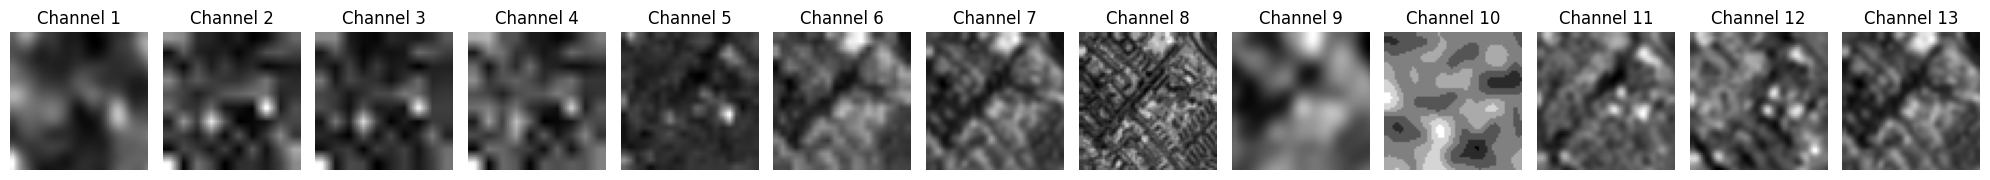

In [14]:
from geobreeze.datasets import GeoBenchDataset
from geobreeze.datasets.utils.augmentations import DownUpSample
from omegaconf import OmegaConf
from geobreeze.factory import make_dataset
import matplotlib.pyplot as plt

# cfg = OmegaConf.load('/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/config/data/m-eurosat_bandgsd.yaml')
# cfg =cfg.train

# ds = make_dataset(cfg)

for res in [0.16]:

    ds = GeoBenchDataset(
        ds_name = 'm-eurosat',
        split = 'train',
        withmetainfo_trf_list = [
            DownUpSample(
                **{'1': str(res), '2': str(res), '3': str(res), '4': '0.33', '5': '0.33'}
            ),
        ],
        normalize=False,
        # band_ids=[1]
    )

    img = ds[0][0]['imgs']

    # plot individual channels
    plt.figure(figsize=(20,10))
    for i in range(img.shape[0]):
        plt.subplot(1, img.shape[0], i + 1)
        plt.imshow(img[i], cmap='gray')
        plt.title(f'Channel {i + 1}')
        plt.axis('off')
    plt.tight_layout()
    print(res)
    plt.show()

    # plot rgb image
    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(6, 6))

    # img = (img - img.min()) / (img.max() - img.min())
    # plt.imshow(img.permute(1, 2, 0))
    # plt.title(f'RGB Image ({res} m GSD)')
    # plt.show()

In [62]:
from geobreeze.datasets import GeoBenchDataset, EurosatSAR, CorineDataset, SpaceNet1Dataset, BenV2Dataset, DigitalTyphoon, TropicalCyclone

# ds = TropicalCyclone(
#     root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/TropicalCyclone',
#     split = 'val',

# )

# ds = DigitalTyphoon(
#     root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/DigitalTyphoon',
#     split = 'train',
#     # band_ids = [0,0,0]
# )

# ds = BenV2Dataset(
#     root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/benv2',
#     split = 'train',
#     bands = 's2',
#     num_classes = 19
# )

# ds = SpaceNet1Dataset(
#     root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/spacenet1',
#     split = 'train',
#     band_ids = [4,2,1])


ds = CorineDataset(
    root = os.path.expandvars('$DATASETS_DIR/spectral_earth'),
    split = 'train',
    # band_ids = [2,5]
)

# ds = GeoBenchDataset(
#     ds_name = 'm-eurosat',
#     split = 'train',
#     # band_ids=[0,4,4]
# )


# ds[0][0]['imgs'].shape
print(len(ds))
print(ds[0][0]['imgs'].shape)
print(ds[0][1])


8250
torch.Size([202, 128, 128])
tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0])


In [71]:
ds[0][0]['srf_filename']

['blue.npy']

237871

In [15]:
import torch
import random

for _ in range(100):

    idx = random.randint(0, len(ds)-1)  
    x = ds.dataset[idx]['image']

    assert torch.allclose(x[0], x[1])
    assert torch.allclose(x[0], x[2])
    assert torch.allclose(x[2], x[1])

In [16]:
ds.dataset[idx]['image'].shape

torch.Size([3, 366, 366])

In [17]:
ds.dataset[idx]['label']

tensor(40)

In [4]:
len(ds.dataset)

104937

In [24]:
ds[0]

({'imgs': tensor([[[-0.3892, -0.3738, -0.3838,  ..., -0.2392, -0.2137, -0.2237],
           [-0.3819, -0.3838, -0.3810,  ..., -0.2192, -0.2019, -0.2155],
           [-0.3528, -0.3874, -0.4101,  ..., -0.2074, -0.1883, -0.1964],
           ...,
           [-0.2037, -0.2283, -0.2565,  ..., -0.3574, -0.3610, -0.3665],
           [-0.2364, -0.2264, -0.2246,  ..., -0.3719, -0.3510, -0.3292],
           [-0.2392, -0.1983, -0.2146,  ..., -0.3665, -0.3565, -0.3574]],
  
          [[-0.3933, -0.4079, -0.4079,  ..., -0.2346, -0.2129, -0.2147],
           [-0.3924, -0.3825, -0.4106,  ..., -0.2265, -0.2047, -0.2002],
           [-0.3480, -0.3924, -0.4079,  ..., -0.1993, -0.1839, -0.1703],
           ...,
           [-0.1993, -0.2047, -0.2392,  ..., -0.4033, -0.4051, -0.3970],
           [-0.2056, -0.2102, -0.2065,  ..., -0.4060, -0.3906, -0.3734],
           [-0.2156, -0.1784, -0.1975,  ..., -0.4051, -0.3897, -0.3698]]]),
  'band_ids': tensor([2, 5]),
  'chn_ids': tensor([429.4570, 444.6990]),
  'g

In [3]:
from geobreeze.datasets import GeoBenchDataset, EurosatSAR

ds = GeoBenchDataset(
    ds_name = 'm-eurosat',
    split = 'train',
    band_ids=[0,4,4]
)
ds[0][0]['imgs'].shape



INFO:eval:Subsampled 3/13 bands with ids [0, 4, 4]. Band names are:
  000: 01 - Coastal aerosol
  001: 05 - Vegetation Red Edge
  002: 05 - Vegetation Red Edge


torch.Size([3, 64, 64])

In [4]:
len(ds)

2000

In [19]:
ds = EurosatSAR(
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/eurosat_SAR',
    split = 'train')

NameError: name 'EurosatSAR' is not defined

In [2]:
import torch

model = torch.hub.load('Panopticon-FM/panopticon','panopticon_vitb14')
x_dict = dict(
  imgs = torch.randn(2, 3, 112, 112),  # (B, C, H, W)
  chn_ids = torch.tensor([[664, 559, 493]]).repeat(2,1)  # (B, C), RGB wavelengths in nm
)

# get image-level features (for classification, regression, ...)
normed_cls_token = model(x_dict)

Using cache found in /home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/Panopticon-FM_panopticon_main
100%|██████████| 378M/378M [00:00<00:00, 480MB/s] 


In [46]:
ds[0]

({'imgs': tensor([[[ 3.0698e-02,  4.6483e-01, -1.6225e-01,  ...,  9.4702e-01,
            -7.7310e-01,  5.2904e-01],
           [ 1.4619e-02,  4.4875e-01,  3.0698e-02,  ..., -4.9981e-01,
             5.1297e-01,  1.9145e-01],
           [ 5.1307e-01,  3.8443e-01, -5.1598e-01,  ...,  1.4616e-02,
            -3.7120e-01, -3.7120e-01],
           ...,
           [-8.1851e-02, -8.8575e-01, -5.9634e-01,  ..., -4.0334e-01,
            -1.5446e+00,  1.2363e+00],
           [ 1.1240e+00, -8.8575e-01, -1.7832e-01,  ..., -1.0785e+00,
             3.2004e-01,  7.8914e-02],
           [ 8.0245e-01,  7.7028e-01, -5.1595e-01,  ...,  7.0584e-01,
             2.5574e-01,  1.2524e+00]],
  
          [[-7.5998e-01, -7.1082e-01, -7.3540e-01,  ..., -4.7484e-01,
            -4.0601e-01, -3.9617e-01],
           [-7.2557e-01, -7.7965e-01, -8.1161e-01,  ..., -4.6992e-01,
            -5.7562e-01, -5.6087e-01],
           [-6.5920e-01, -7.6982e-01, -8.4110e-01,  ..., -4.2321e-01,
            -5.9529e-01, -5.95

In [47]:
ds.ds_config

{'ds_name': 'm-so2sat', 'bands': [{'name': '01 - VH.Real', 'gaussian': {'mu': -2, 'sigma': -1}, 'orbit': 'BOTH', 'id': 'sentinel1/B02'}, {'name': '02 - Blue', 'gaussian': {'mu': 492.9971095687347, 'sigma': 23.810316659477703}, 'GSD': 10, 'id': 'sentinel2/B02'}, {'name': '02 - VH.Imaginary', 'gaussian': {'mu': 0}}, {'name': '03 - Green', 'gaussian': {'mu': 559.5987534818435, 'sigma': 12.768882177939654}, 'GSD': 10, 'id': 'sentinel2/B03'}, {'name': '03 - VV.Real', 'gaussian': {'mu': -1, 'sigma': -1}, 'orbit': 'BOTH', 'id': 'sentinel1/B01'}, {'name': '04 - Red', 'gaussian': {'mu': 664.6300422881802, 'sigma': 11.757355524910432}, 'GSD': 10, 'id': 'sentinel2/B04'}, {'name': '04 - VV.Imaginary', 'gaussian': {'mu': 0}}, {'name': '05 - VH.LEE Filtered', 'gaussian': {'mu': 0}}, {'name': '05 - Vegetation Red Edge', 'gaussian': {'mu': 704.0059319834206, 'sigma': 5.362493403740522}, 'GSD': 20, 'id': 'sentinel2/B05'}, {'name': '06 - VV.LEE Filtered', 'gaussian': {'mu': 0}}, {'name': '06 - Vegetatio

In [48]:
for i, b in enumerate(ds.ds_config['bands']):
    print(f"{i}: {b['name']}")

0: 01 - VH.Real
1: 02 - Blue
2: 02 - VH.Imaginary
3: 03 - Green
4: 03 - VV.Real
5: 04 - Red
6: 04 - VV.Imaginary
7: 05 - VH.LEE Filtered
8: 05 - Vegetation Red Edge
9: 06 - VV.LEE Filtered
10: 06 - Vegetation Red Edge
11: 07 - VH.LEE Filtered.Real
12: 07 - Vegetation Red Edge
13: 08 - NIR
14: 08 - VV.LEE Filtered.Imaginary
15: 08A - Vegetation Red Edge
16: 11 - SWIR
17: 12 - SWIR


In [14]:
import geobench

task_iter = geobench.task_iterator(benchmark_name='classification_v1.0')
tasks = {task.dataset_name: task for task in task_iter}
task = tasks.get('m-forestnet')


In [15]:
print(tasks.keys())

dict_keys(['m-forestnet', 'm-bigearthnet', 'm-brick-kiln', 'm-pv4ger', 'm-so2sat', 'm-eurosat'])


In [19]:
task.get_dataset()[0].bands

[Band(info=Band 04 - Red (15.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 03 - Green (15.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 02 - Blue (15.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 05 - NIR (30.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 06 - SWIR1 (30.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 07 - SWIR2 (30.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01)]

In [19]:
ds = task.get_dataset()
ds.band_stats

{'01 - VH.Real': <geobench.dataset.Stats at 0x145ab082e150>,
 '02 - Blue': <geobench.dataset.Stats at 0x145ab014f410>,
 '02 - VH.Imaginary': <geobench.dataset.Stats at 0x145ab014c250>,
 '03 - Green': <geobench.dataset.Stats at 0x145ab014f650>,
 '03 - VV.Real': <geobench.dataset.Stats at 0x145ab014c410>,
 '04 - Red': <geobench.dataset.Stats at 0x145ab014f710>,
 '04 - VV.Imaginary': <geobench.dataset.Stats at 0x145ab014f090>,
 '05 - VH.LEE Filtered': <geobench.dataset.Stats at 0x145ab014f9d0>,
 '05 - Vegetation Red Edge': <geobench.dataset.Stats at 0x145ab014d910>,
 '06 - VV.LEE Filtered': <geobench.dataset.Stats at 0x145ab014c150>,
 '06 - Vegetation Red Edge': <geobench.dataset.Stats at 0x145ab014ff90>,
 '07 - VH.LEE Filtered.Real': <geobench.dataset.Stats at 0x145ab014fcd0>,
 '07 - Vegetation Red Edge': <geobench.dataset.Stats at 0x145ab014f450>,
 '08 - NIR': <geobench.dataset.Stats at 0x145ab014c1d0>,
 '08 - VV.LEE Filtered.Imaginary': <geobench.dataset.Stats at 0x145ab014f5d0>,
 '08A

In [40]:
band_names = ['VH.Real', '02 - Blue', '03 - Green', 'VV.Real', '04 - Red', '05 - Vegetation Red Edge', '06 - Vegetation Red Edge', '07 - Vegetation Red Edge', '08 - NIR', '08A - Vegetation Red Edge', '11 - SWIR', '12 - SWIR']

for b in band_names:
    print(b)
    task.get_dataset(band_names=[b])

VH.Real


TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
task.get_dataset

In [38]:
for split in ['train','valid','test']:
    ds = task.get_dataset(split=split)
    print(ds.normalization_stats())

([0.11374464631080627, 0.11734361201524734, 0.12951652705669403], [0.07254913449287415, 0.05125178396701813, 0.040680479258298874])
([0.11374464631080627, 0.11734361201524734, 0.12951652705669403], [0.07254913449287415, 0.05125178396701813, 0.040680479258298874])
([0.11374464631080627, 0.11734361201524734, 0.12951652705669403], [0.07254913449287415, 0.05125178396701813, 0.040680479258298874])


In [22]:
sample = ds[0]
x, band_names = sample.pack_to_3d(
            band_names=None,
            resample=False,
            fill_value=None,
            resample_order=3,
        )  # h,w,c
print(band_names)
x.shape

['01 - VH.Real', '02 - VH.Imaginary', '03 - VV.Real', '04 - VV.Imaginary', '05 - VH.LEE Filtered', '06 - VV.LEE Filtered', '07 - VH.LEE Filtered.Real', '08 - VV.LEE Filtered.Imaginary', '02 - Blue', '03 - Green', '04 - Red', '05 - Vegetation Red Edge', '06 - Vegetation Red Edge', '07 - Vegetation Red Edge', '08 - NIR', '08A - Vegetation Red Edge', '11 - SWIR', '12 - SWIR']


(32, 32, 18)

In [4]:
from geobreeze.datasets.eurosat_sar import EurosatSAR

ds = EurosatSAR(
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/eurosat_SAR',
    split = 'train',
)
ds[0]

({'imgs': tensor([[[-2.7080e-01, -5.4614e-01, -3.7763e-01,  ..., -7.2110e-02,
            -1.4928e-01, -4.2704e-01],
           [-1.5654e-01, -3.1059e-01, -7.5464e-01,  ...,  2.7207e-01,
            -3.3467e-02, -4.5046e-01],
           [-1.1821e-02, -1.0553e-04, -2.6918e-01,  ...,  1.9445e-01,
            -7.8714e-03, -5.4175e-01],
           ...,
           [-6.3042e-01, -6.9635e-01, -7.7202e-01,  ..., -8.7158e-01,
            -7.3859e-01, -7.4496e-01],
           [-3.0660e-01, -4.5022e-01, -4.4074e-01,  ..., -5.3909e-01,
            -7.9322e-01, -6.4643e-01],
           [-1.8874e-01, -9.9575e-02,  6.5315e-02,  ...,  1.6061e-01,
            -1.7713e-01, -3.0293e-01]],
  
          [[-2.2498e-01, -2.2255e-02, -3.4457e-01,  ..., -5.2778e-01,
            -7.0583e-01, -6.0284e-01],
           [-2.6444e-01, -1.1559e-01, -5.7297e-01,  ..., -3.6920e-01,
            -6.6455e-01, -5.9564e-01],
           [-3.0854e-01, -1.9089e-01, -2.9349e-01,  ...,  3.3168e-02,
            -3.2387e-01, -3.88

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/random_chns/m-eurosat'

collect_csv(p)
df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


df = df[df['metric'] == 'acc_top-1_micro']
df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
df['nchns'] = df['relpath'].apply(lambda x: x.split('/')[1])


dfplot = df.groupby(['nchns', 'model'])['val'].agg(['mean', 'std']).reset_index()
dfplot['nchns'] = pd.to_numeric(dfplot['nchns'])
dfplot.sort_values('nchns', inplace=True)
dfplot.fillna(0.0, inplace=True)
display(dfplot)

,nchns,model,mean,std
0,3,dinov2,82.7505,3.810934


### GSD invariance

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os
import numpy as np


def plot_gsd_inv(p, ax=None, collect=True, exclude = [], even_xticks=False):
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_inv'
    if collect:
        collect_csv(os.path.join(root,p))
    df = pd.read_csv(os.path.join(root,p,'results.csv')).drop(columns=['Unnamed: 0'])

    df = df[df['metric'] == 'acc_top-1_micro']
    df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['size'] = df['relpath'].apply(lambda x: x.split('/')[1])
    # display(df)
    if df['val'].max() < 1.0:
        df['val'] = df['val'] * 100.0

    dfplot = df.groupby(['size', 'model'])['val'].agg(['mean', 'std']).reset_index()
    dfplot['size'] = pd.to_numeric(dfplot['size'])
    dfplot.sort_values('size', inplace=True)
    dfplot.fillna(0.0, inplace=True)


    # Plot mean with ± std as bands
    standalone = ax is None
    if standalone:
        fig, ax = plt.subplots(figsize=(6, 4))

    for model in reversed(MODEL_TO_AESTETICS.keys()):
        if model not in dfplot['model'].unique() or model in exclude:
            continue
        model_data = dfplot[dfplot['model'] == model]
        color, marker, model_name = get_aestetics(model)
        xdata = model_data['size']
        if even_xticks:
            xdata = np.arange(len(xdata))
        ax.plot(xdata, model_data['mean'], label=model_name, color=color, marker=marker)
        ax.fill_between(xdata, 
                        model_data['mean'] - model_data['std'], 
                        model_data['mean'] + model_data['std'], 
                        alpha=0.2,
                        color=color )
        
    ax.set_xlabel('percentage of full resolution')
    ax.set_ylabel('Value')
    ax.set_title(p)
    ax.grid(True)
    

    if standalone:
        plt.legend()
        plt.show()


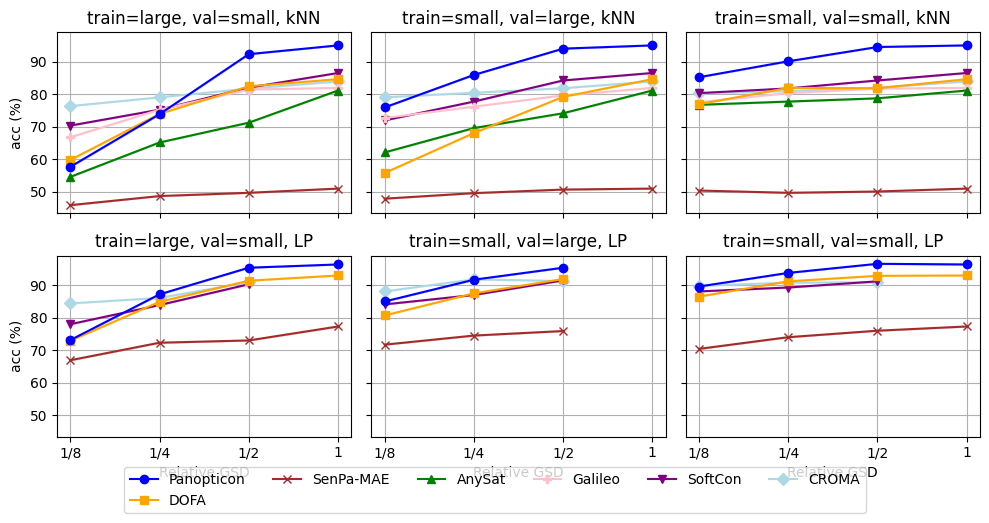

In [3]:
#### plot eurosat

names = {
    'only_val': 'train=large, val=small',
    'only_train': 'train=small, val=large',
    'also_train': 'train=small, val=small',
}

fig, axs = plt.subplots(2,3, figsize=(10, 5), sharex=True, sharey=True)
axs = axs.flatten()

kwargs = dict(collect=True, exclude=['dinov2'], even_xticks=True)
# kwargs = dict(collect=False, even_xticks=True)

def set_ax(ax):
    ax.set_ylabel('')
    ax.set_xlabel('')
    # ax.set_xticks([12.5, 25, 50, 100])
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['1/8', '1/4', '1/2', '1'])
    ax.grid(True)

ax = axs[0]
plot_gsd_inv('only_val/m-eurosat/knn', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=large, val=small, kNN')
ax.set_ylabel('acc (%)')

ax = axs[1]
plot_gsd_inv('only_train/m-eurosat/knn', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=large, kNN')

ax = axs[2]
plot_gsd_inv('also_train/m-eurosat/knn', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=small, kNN')

ax = axs[3]
plot_gsd_inv('only_val/m-eurosat/linear_probe', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=large, val=small, LP')
ax.set_ylabel('acc (%)')
ax.set_xlabel('Relative GSD')

ax = axs[4]
plot_gsd_inv('only_train/m-eurosat/linear_probe', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=large, LP')
ax.set_xlabel('Relative GSD')

ax = axs[5]
plot_gsd_inv('also_train/m-eurosat/linear_probe', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=small, LP')
ax.set_xlabel('Relative GSD')



fig.legend(
    handles=reversed(axs[0].get_legend_handles_labels()[0]), 
    labels=reversed(axs[0].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05), 
    ncol=6)

plt.tight_layout()
plt.show()

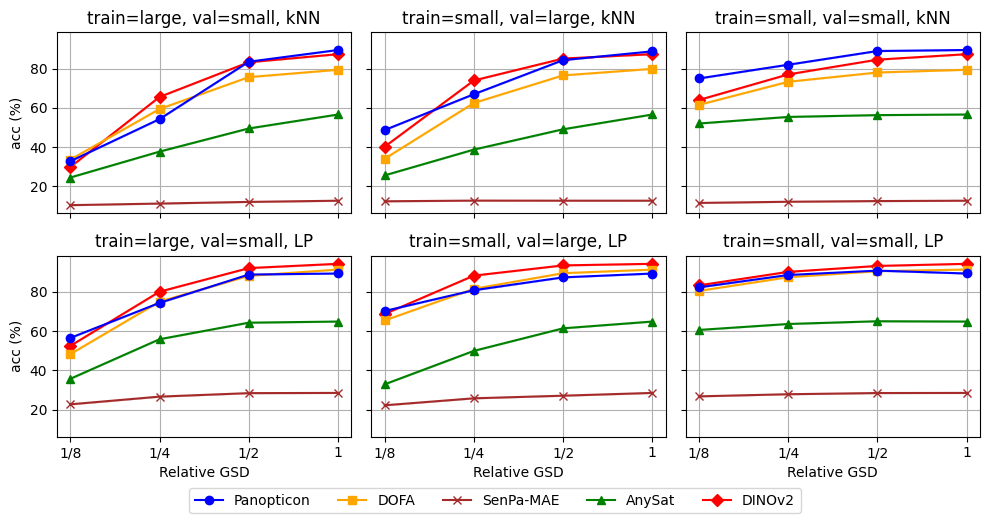

In [39]:
#### plot resisc
import matplotlib.pyplot as plt

names = {
    'only_val': 'train=large, val=small',
    'only_train': 'train=small, val=large',
    'also_train': 'train=small, val=small',
}

fig, axs = plt.subplots(2,3, figsize=(10, 5), sharex=True, sharey=True)
axs = axs.flatten()

# kwargs = dict(collect=False, exclude=['senpamae'], even_xticks=True)
kwargs = dict(collect=False, even_xticks=True)

def set_ax(ax):
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_ylabel('acc (%)')
    # ax.set_xlabel('Relative GSD')
    # ax.set_xticks([12.5, 25, 50, 100])
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['1/8', '1/4', '1/2', '1'])
    ax.grid(True)

ax = axs[0]
plot_gsd_inv('only_val/resisc45/knn', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=large, val=small, kNN')
ax.set_ylabel('acc (%)')

ax = axs[1]
plot_gsd_inv('only_train/resisc45/knn', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=large, kNN')

ax = axs[2]
plot_gsd_inv('also_train/resisc45/knn', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=small, kNN')

ax = axs[3]
plot_gsd_inv('only_val/resisc45/linear_probe', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=large, val=small, LP')
ax.set_xlabel('Relative GSD')
ax.set_ylabel('acc (%)')

ax = axs[4]
plot_gsd_inv('only_train/resisc45/linear_probe', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=large, LP')
ax.set_xlabel('Relative GSD')

ax = axs[5]
plot_gsd_inv('also_train/resisc45/linear_probe', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=small, LP')
ax.set_xlabel('Relative GSD')



fig.legend(
    handles=reversed(axs[0].get_legend_handles_labels()[0]), 
    labels=reversed(axs[0].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05), 
    ncol=6)

plt.tight_layout()
plt.show()

also_train/resisc45/knn
also_train/resisc45/linear_probe
only_val/resisc45/knn
only_val/resisc45/linear_probe


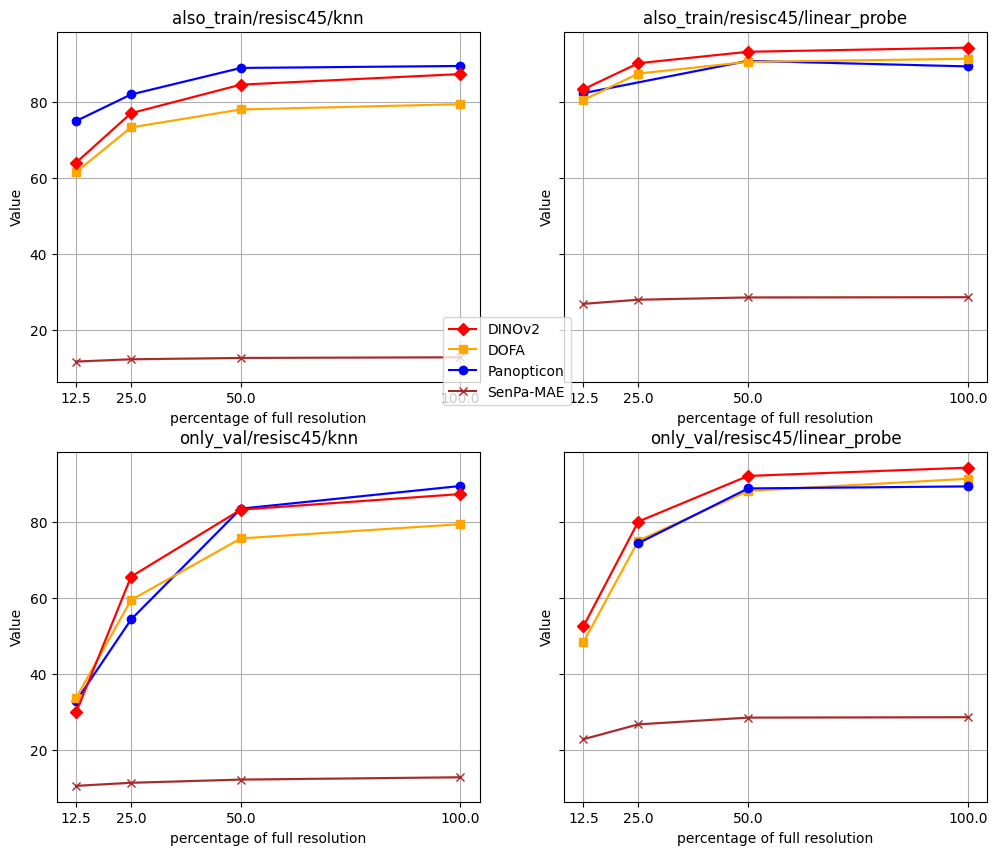

In [ ]:
#### plot resissc

root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_inv'
folders = [
    'also_train/resisc45/knn',
    'also_train/resisc45/linear_probe',
    'only_val/resisc45/knn',
    'only_val/resisc45/linear_probe',
]

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axs = axs.flatten()

for i, folder in enumerate(folders):
    print(folder)
    ax = axs[i]
    plot_gsd_inv(os.path.join(root, folder), collect=True, ax=ax)
    ax.set_title(folder)
    ax.set_xticks([12.5, 25, 50,100])


fig.legend(
    handles=reversed(axs[0].get_legend_handles_labels()[0]), 
    labels=reversed(axs[0].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, 0.5), 
    ncol=1)
plt.show()

also_train/m-brick-kiln/knn
also_train/m-brick-kiln/linear_probe
only_val/m-brick-kiln/knn
only_val/m-brick-kiln/linear_probe


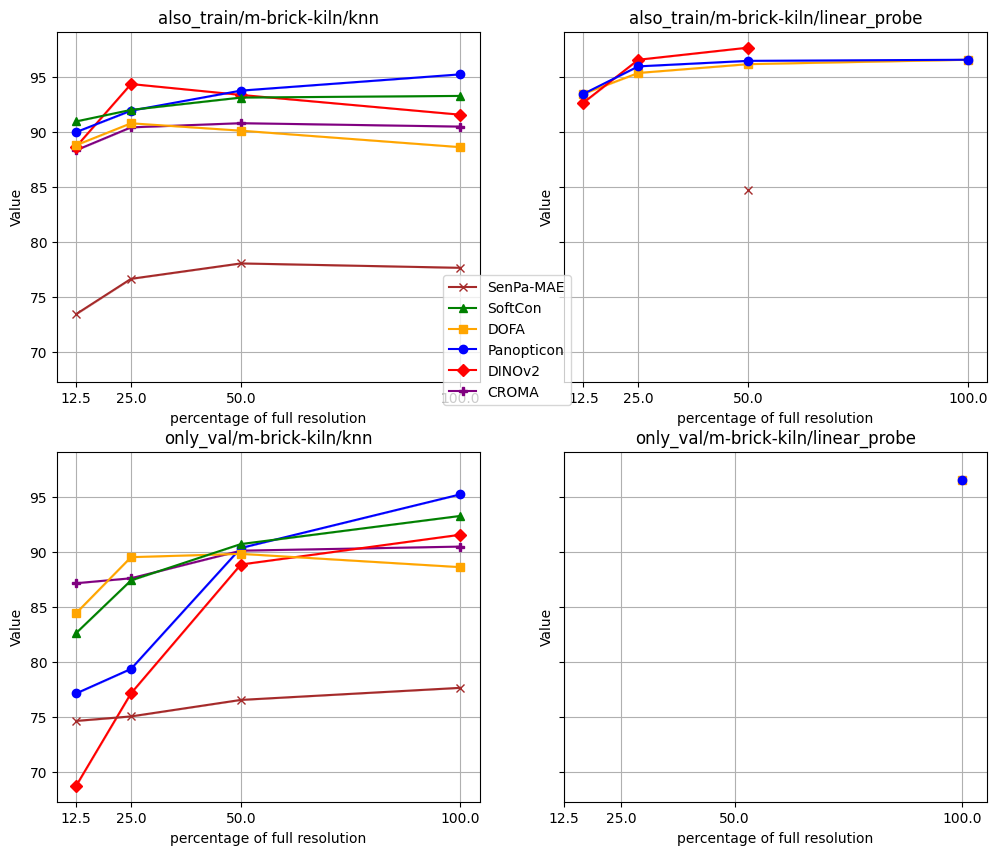

In [6]:
#### plot m-brick-kiln

folders = [
    'also_train/m-brick-kiln/knn',
    'also_train/m-brick-kiln/linear_probe',
    'only_val/m-brick-kiln/knn',
    'only_val/m-brick-kiln/linear_probe',
]

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axs = axs.flatten()

for i, folder in enumerate(folders):
    print(folder)
    ax = axs[i]
    plot_gsd_inv(folder, collect=True, ax=ax)
    ax.set_title(folder)
    ax.set_xticks([12.5, 25, 50,100])


fig.legend(
    handles=reversed(axs[0].get_legend_handles_labels()[0]), 
    labels=reversed(axs[0].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, 0.5), 
    ncol=1)
plt.show()

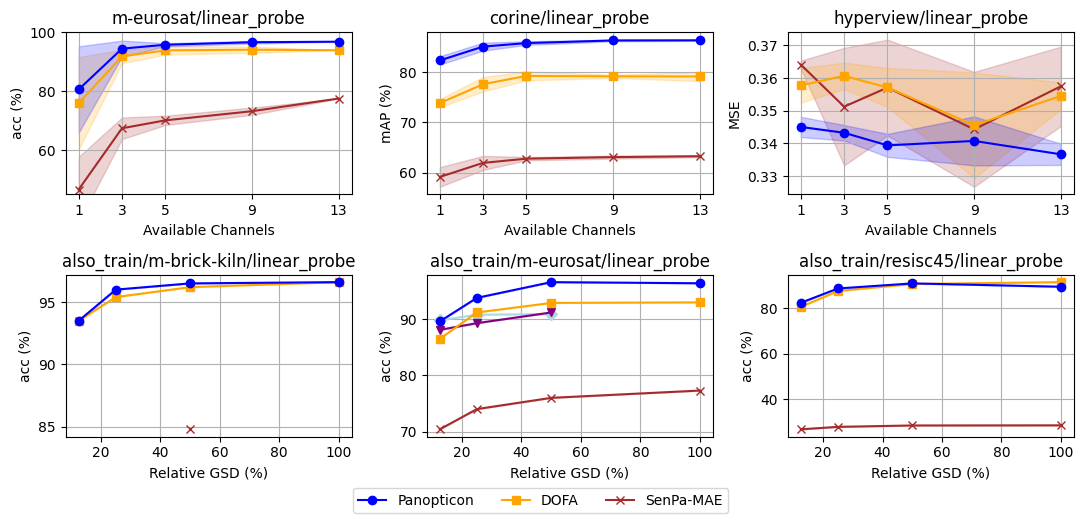

In [9]:
""" joint figure """

import matplotlib.pyplot as plt
import os

fig, axes = plt.subplots(2, 3, figsize=(11, 5))
axes = axes.flatten()

kwargs = dict(collect=False, dinov2=False, verbose=False, chn_ids=[1,3,5,9,13])

# plot_spec_inv('m-eurosat/knn', ax=axes[0], drop=('senpamae',1), **kwargs)
# # plot_spec_inv('m-eurosat/knn', ax=axes[0], **kwargs)
# axes[0].set_ylim(45,100)
# axes[0].set_ylabel('acc (%)')
# axes[0].set_xlabel('Number of Channels')

ax = axes[0]
plot_spec_inv('m-eurosat/linear_probe', ax=ax, **kwargs)
ax.set_ylim(45,100)
ax.set_ylabel('acc (%)')
ax.set_xlabel('Available Channels')

ax = axes[1]
plot_spec_inv('corine/linear_probe', metric='MulLabAvergPrec_micro', ax=ax, **kwargs)
ax.set_ylabel('mAP (%)')
ax.set_xlabel('Available Channels')

ax = axes[2]
plot_spec_inv('hyperview/linear_probe', ax=ax, metric='MSE', **kwargs)
ax.set_ylabel('MSE')
ax.set_xlabel('Available Channels')

ax=axes[3]
plot_gsd_inv('also_train/m-brick-kiln/linear_probe', ax=ax, collect=False, exclude=['dinov2'])
ax.set_ylabel('acc (%)')
ax.set_xlabel('Relative GSD (%)')

ax=axes[4]
plot_gsd_inv('also_train/m-eurosat/linear_probe', ax=ax, collect=False, exclude=['dinov2'] )
ax.set_ylabel('acc (%)')
ax.set_xlabel('Relative GSD (%)')

ax=axes[5]
plot_gsd_inv('also_train/resisc45/linear_probe', ax=ax, collect=False, exclude=['dinov2'] )
ax.set_ylabel('acc (%)')
ax.set_xlabel('Relative GSD (%)')

# fig.suptitle('test')
fig.legend(
    handles=reversed(axes[3].get_legend_handles_labels()[0]), 
    labels=reversed(axes[3].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05), 
    ncol=6)

plt.tight_layout()
plt.show()

figroot = '/home/hk-project-pai00028/tum_mhj8661/code/z_figs'


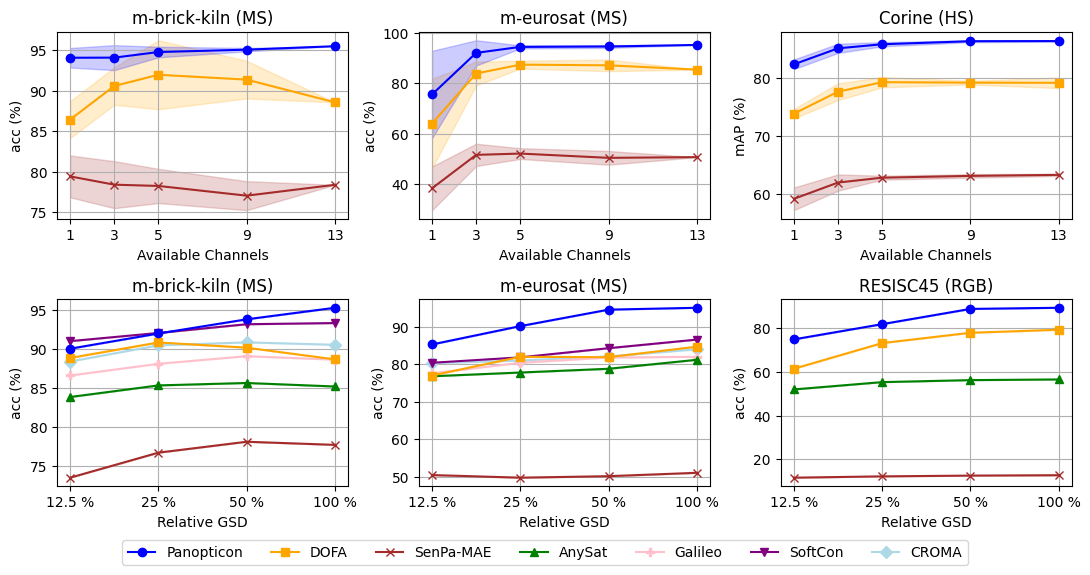

In [7]:
""" re-create figure from submissino """

import matplotlib.pyplot as plt
import os

fig, axes = plt.subplots(2, 3, figsize=(11, 5.5))
axes = axes.flatten()
plt.tight_layout()

kwargs = dict(dinov2=False, verbose=False, chn_ids=[1,3,5,9,13])


ax = axes[0]
plot_spec_inv('m-brick-kiln_knn/knn', ax=ax, collect=False, **kwargs)
# ax.set_ylim(40,100)
ax.set_ylabel('acc (%)')
# ax.set_ylabel('acc / mAP (%)')
ax.set_xlabel('Available Channels')
ax.set_title('m-brick-kiln (MS)')

ax = axes[1]
plot_spec_inv('m-eurosat/knn', ax=ax, collect=False, **kwargs)
# ax.set_ylim(30,99)
ax.set_ylabel('acc (%)')
# ax.set_ylabel('')
ax.set_xlabel('Available Channels')
ax.set_title('m-eurosat (MS)')

ax = axes[2]
plot_spec_inv('corine/linear_probe', collect=False, metric='MulLabAvergPrec_micro', ax=ax, **kwargs)
# ax.set_ylim(40,100)
ax.set_ylabel('mAP (%)')
# ax.set_ylabel('')
ax.set_xlabel('Available Channels')
ax.set_title('Corine (HS)')

ax=axes[3]
plot_gsd_inv('also_train/m-brick-kiln/knn', ax=ax, collect=False, exclude=['dinov2'], even_xticks=True)
ax.set_ylabel('acc (%)')
ax.set_xlabel('Relative GSD')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['12.5 %', '25 %', '50 %', '100 %'])
ax.set_title('m-brick-kiln (MS)')
# ax.set_ylim(30,100)

ax=axes[4]
plot_gsd_inv('also_train/m-eurosat/knn', ax=ax, collect=False, exclude=['dinov2'], even_xticks=True)
ax.set_ylabel('acc (%)')
# ax.set_ylabel('')
ax.set_xlabel('Relative GSD')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['12.5 %', '25 %', '50 %', '100 %'])
ax.set_title('m-eurosat (MS)')
# ax.set_ylim(30,100)

ax=axes[5]
plot_gsd_inv('also_train/resisc45/knn', ax=ax, collect=False,even_xticks=True, exclude=['dinov2'] )
ax.set_ylabel('acc (%)')
# ax.set_ylabel('')
ax.set_xlabel('Relative GSD')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['12.5 %', '25 %', '50 %', '100 %'])
ax.set_title('RESISC45 (RGB)')
# ax.set_ylim(0,100)

# fig.suptitle('test')
fig.legend(
    handles=reversed(axes[4].get_legend_handles_labels()[0]), 
    labels=reversed(axes[4].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05), 
    ncol=7)

plt.tight_layout()
plt.show()

figroot = '/home/hk-project-pai00028/tum_mhj8661/code/z_figs'
# fig.savefig(os.path.join(figroot,"gsd_spec_inv_updated.pdf"), format="pdf", bbox_inches='tight')


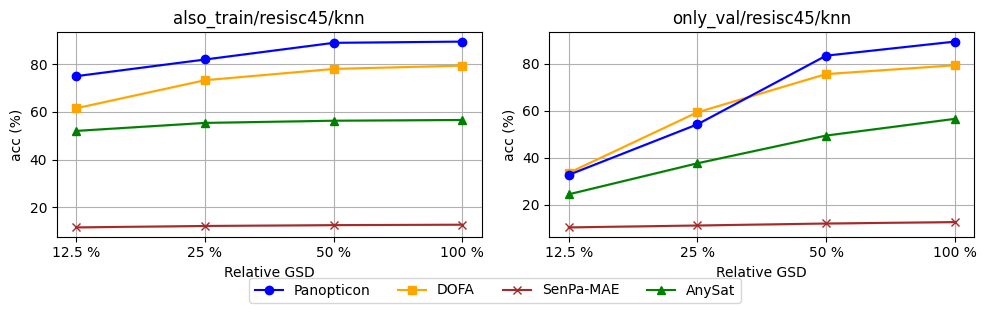

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.flatten()

ax = axes[0]
plot_gsd_inv('also_train/resisc45/knn', ax=ax, collect=False, even_xticks=True, exclude=['dinov2'] )
ax.set_ylabel('acc (%)')
ax.set_xlabel('Relative GSD')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['12.5 %', '25 %', '50 %', '100 %'])
# ax.set_title('RESISC45 (RGB)')

ax = axes[1]
plot_gsd_inv('only_val/resisc45/knn', ax=ax, collect=False, even_xticks=True, exclude=['dinov2'] )
ax.set_ylabel('acc (%)')
ax.set_xlabel('Relative GSD')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['12.5 %', '25 %', '50 %', '100 %'])
# ax.set_title('RESISC45 (RGB)')

fig.legend(
    handles=reversed(axes[0].get_legend_handles_labels()[0]), 
    labels=reversed(axes[0].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05), 
    ncol=7)

plt.tight_layout()
plt.show()

,prc,model,mean,std,count
0,12.5,dofa,86.100000,0.0,1
1,16.6,dofa,89.800000,0.0,1
2,16.6,panopticon,92.600000,0.0,1
3,25.0,dofa,91.299999,0.0,1
4,25.0,panopticon,93.699998,0.0,1
5,50.0,dofa,92.299998,0.0,1
6,50.0,panopticon,96.700001,0.0,1
7,100.0,dofa,93.900001,0.0,1
8,100.0,panopticon,96.799999,0.0,1


,prc,model,mean,std,count
0,12.5,dofa,72.899997,0.0,1
1,12.5,panopticon,73.699999,0.0,1
2,25.0,dofa,85.000002,0.0,1
3,25.0,panopticon,86.100000,0.0,1
4,50.0,dofa,91.600001,0.0,1
5,50.0,panopticon,95.400000,0.0,1
6,100.0,dofa,93.900001,0.0,1
7,100.0,panopticon,96.799999,0.0,1


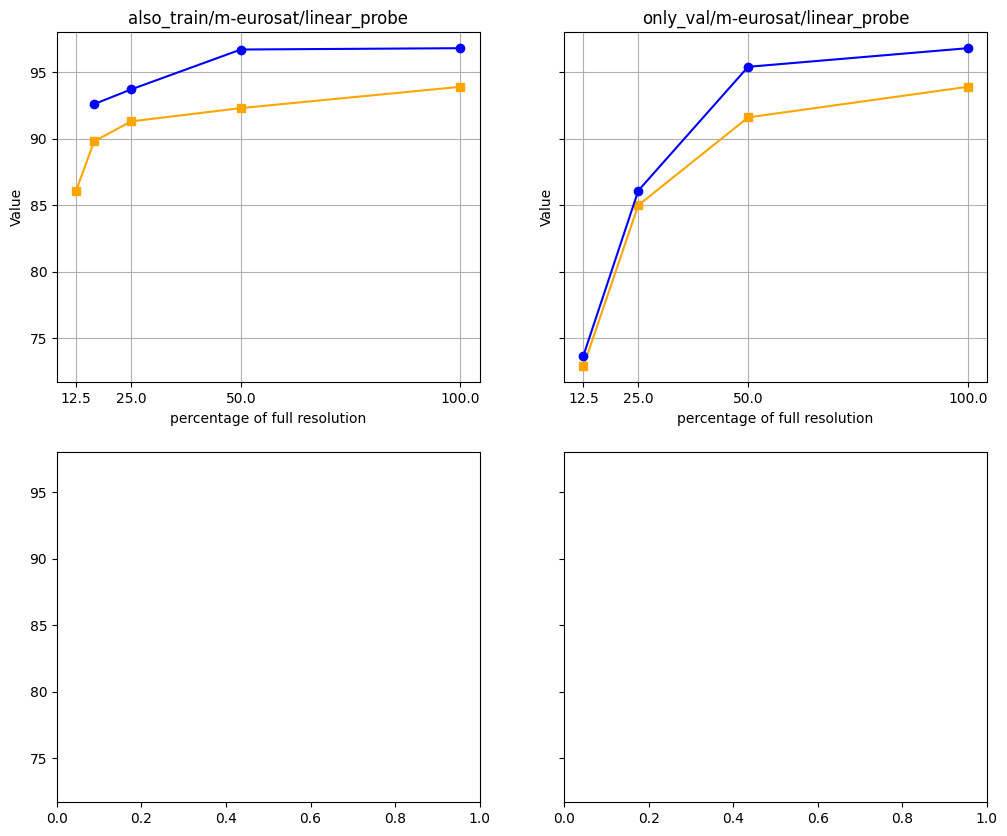

In [ ]:
""" new gsd invariance """

import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os


def plot_gsd(ds_name, metric='acc_top-1_micro', collect=True, ax=None, dinov2=True, nchns=13, mode='linear_probe', verbose=True):
    
    # get the df
    
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_spec_inv/'
    
    p = os.path.join(root, ds_name)
    if collect:
        collect_csv(p)
    df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


    df = df[df['metric'] == metric]
    df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['mode'] = df['relpath'].apply(lambda x: x.split('/')[1])
    df = df[df['mode'] == mode]
    df['prc'] = pd.to_numeric(df['relpath'].apply(lambda x: x.split('/')[2]))
    df['nchns'] = pd.to_numeric(df['relpath'].apply(lambda x: x.split('/')[3]))
    df = df[df['nchns'] == nchns]
    df['chn_ids'] = df['relpath'].apply(lambda x: x.split('/')[4])
    if not dinov2:
        df = df[~df['model'].isin(['dinov2', 'dinov2-PE'])]

    df = df.groupby(['model','prc','nchns','chn_ids'])['val'].agg('max').reset_index()
    df.rename(columns={'max':'val'}, inplace=True)

    if df['val'].max() <= 1.0:
        df['val'] = df['val']*100

    # actually start processing


    dfplot = df.groupby(['prc', 'model'])['val'].agg(['mean','std','count']).reset_index()
    dfplot.sort_values('prc', inplace=True)
    dfplot.fillna(0.0, inplace=True)
    if verbose:
        display(dfplot)

    standalone = ax is None
    if standalone:
        fig, ax = plt.subplots(figsize=(6, 4))

    for model in dfplot['model'].unique():
        model_data = dfplot[dfplot['model'] == model]
        color, marker, model_name = get_aestetics(model)
        ax.plot(model_data['prc'], model_data['mean'], label=model_name, color=color, marker=marker)
        # ax.fill_between(model_data['mean'], 
        #         model_data['mean'] - model_data['std'], 
        #         model_data['mean'] + model_data['std'], 
        #         alpha=0.2,
        #         color=color )
        
    ax.set_xlabel('percentage of full resolution')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.set_title(f'{ds_name}{mode}')

    if standalone:
        plt.legend()
        plt.show()


fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

ax = axs[0][0]
plot_gsd('also_train/m-eurosat/', collect=False, mode='linear_probe', nchns=13, ax=ax)
ax.set_xticks([12.5, 25, 50,100])

ax = axs[0][1]
plot_gsd('only_val/m-eurosat/', collect=True, mode='linear_probe', nchns=13, ax=ax)
ax.set_xticks([12.5, 25, 50,100])

plt.show()
plt.legend()

### Spectral invariance

corine-10


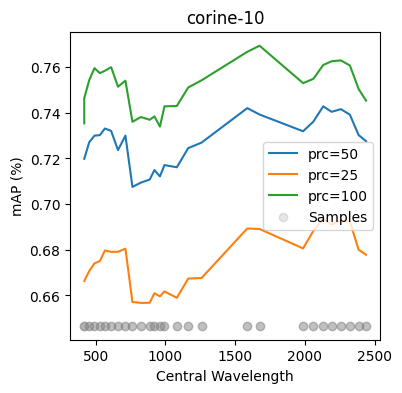

In [ ]:
""" plot corine  """
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os
import numpy as np
from geobreeze.datasets.utils.utils import load_ds_cfg


# ds_name = 'm-eurosat/knn/'
# root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/spec_inv/'
# root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/investigate_chn_influence/'



def fun(ds_name, collect=False, **kwargs):
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_spec_inv/also_train'
    

    print(ds_name)
    p = os.path.join(root, ds_name)
    collect_csv(p) if collect else None
    df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


    df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['train_mode'] = df['relpath'].apply(lambda x: x.split('/')[1])
    df['prc'] = df['relpath'].apply(lambda x: x.split('/')[2])
    df['nchns'] = df['relpath'].apply(lambda x: x.split('/')[3]).astype(int)
    df['ids'] = df['relpath'].apply(lambda x: eval(x.split('/')[4]))

    for k,v in kwargs.items():
        df = df[df[k] == v]
    df = df[df['nchns'] == 1]

    df = df.reset_index()

    bands = load_ds_cfg('corine')['bands']
    mus = [b['gaussian']['mu'] for b in bands]

    # plot graph
    df['id'] = df['ids'].apply(lambda x: x[0])
    df['mu'] = df['id'].apply(lambda x: mus[x])
    df = df.sort_values('mu')

    plt.figure(figsize=(4, 4))
    for prc in df['prc'].unique():
        df_prc = df[df['prc'] == prc]
        plt.plot(df_prc['mu'], df_prc['val'], label=f'{prc}')

    plt.scatter(df['mu'], [df['val'].min() -0.01] * len(df), color='grey', alpha=0.2, label='Samples')
    plt.title(ds_name)
    plt.legend()

fun('corine-10', model='panopticon', train_mode='linear_probe', metric = 'MulLabAvergPrec_micro', collect=False)
plt.xlabel('Central Wavelength (nm)')
plt.ylabel('mAP (%)')
plt.show()

# fun('corine', model='panopticon', train_mode='linear_probe', metric = 'MulLabAvergPrec_micro', collect=False)


corine-10/linear_probe


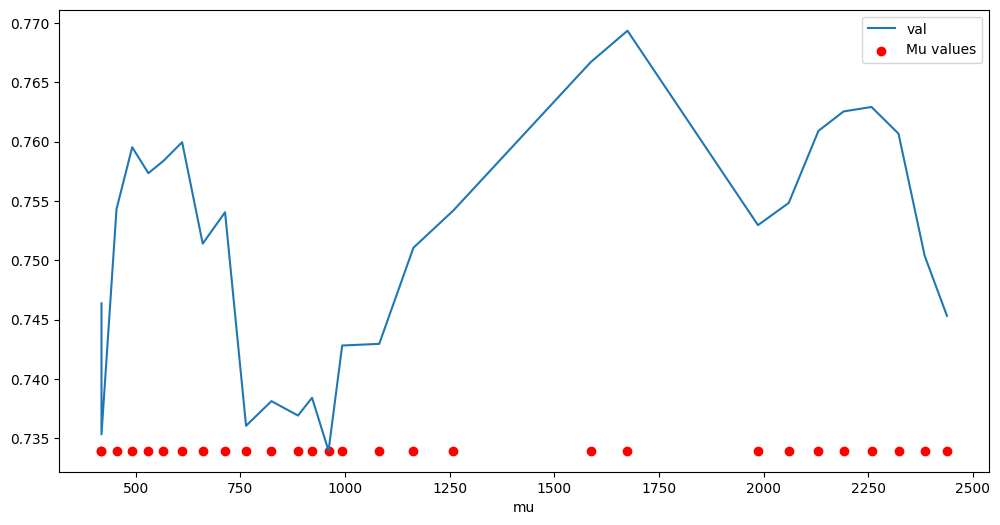

corine/linear_probe


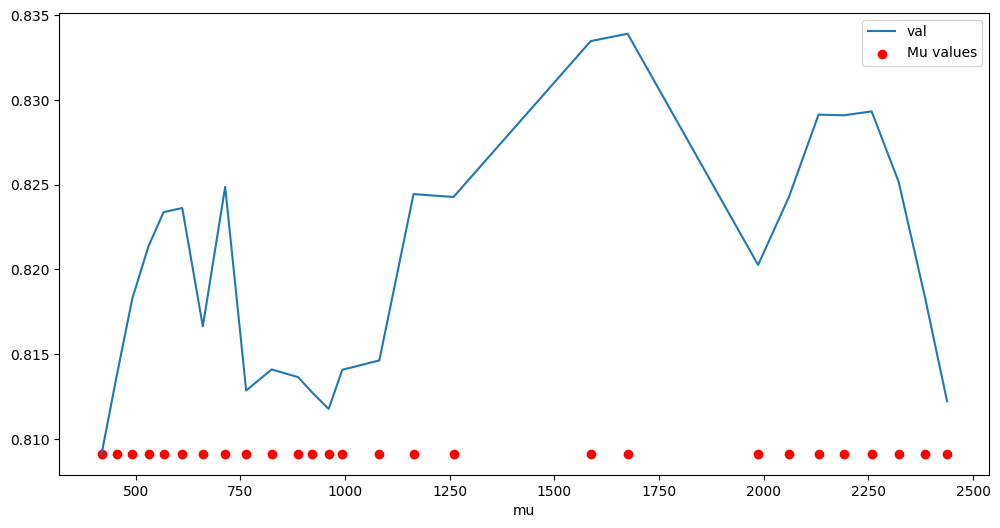

In [ ]:
""" plot corine  """
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os
import numpy as np
from geobreeze.datasets.utils.utils import load_ds_cfg


# ds_name = 'm-eurosat/knn/'
# root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/spec_inv/'
# root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/investigate_chn_influence/'



def fun(ds_name, collect=False):
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/investigate_chn_influence/'
    metric = 'MulLabAvergPrec_micro'

    print(ds_name)
    p = os.path.join(root, ds_name)
    collect_csv(p) if collect else None
    df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


    df = df[df['metric'] == metric]
    df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['nchns'] = df['relpath'].apply(lambda x: x.split('/')[1]).astype(int)
    df['ids'] = df['relpath'].apply(lambda x: eval(x.split('/')[2]))

    df = df[df['nchns'] <= 1]
    df = df[df['model'] == 'panopticon']

    df = df.reset_index()

    bands = load_ds_cfg('corine')['bands']
    mus = [b['gaussian']['mu'] for b in bands]

    # plot graph
    df['id'] = df['ids'].apply(lambda x: x[0])
    df['mu'] = df['id'].apply(lambda x: mus[x])
    df = df.sort_values('mu')
    df.plot(x='mu', y='val', figsize=(12, 6))
    plt.scatter(df['mu'], [df['val'].min()] * len(df), color='red', label='Mu values')
    plt.legend()
    plt.show()

fun('corine-10/linear_probe')
fun('corine/linear_probe', collect=True)

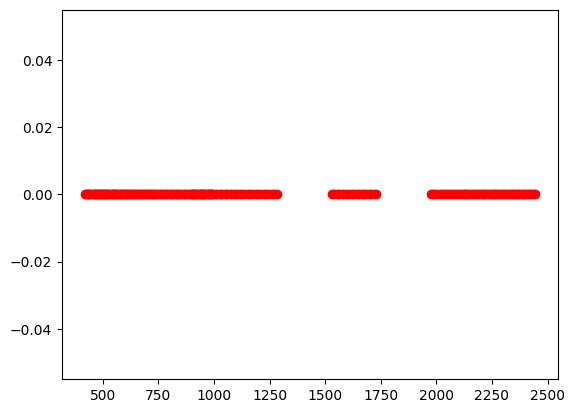

In [191]:
plt.scatter(mus, [0] * len(mus), color='red', label='Mu values')

In [167]:
""" channel correlations """
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os
import numpy as np
from geobreeze.datasets.utils.utils import load_ds_cfg


# ds_name = 'm-eurosat/knn/'
# root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/spec_inv/'
# root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/investigate_chn_influence/'

ds_name = 'm-eurosat_bandgsd_10to20/knn'
root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/investigate_chn_influence/'


def plot_spec_2(ds_name, root, metric = 'acc_top-1_micro', collect=True, _dsname='m-eurosat', mul=False, gsd_map={}):
    print(ds_name)
    p = os.path.join(root, ds_name)
    if collect:
        collect_csv(p)
    df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


    df = df[df['metric'] == metric]
    df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['nchns'] = df['relpath'].apply(lambda x: x.split('/')[1]).astype(int)
    df['ids'] = df['relpath'].apply(lambda x: eval(x.split('/')[2]))
    if mul:
        df['val'] = round(df['val'] * 100, 1)

    df = df[df['nchns'] == 3]
    df = df[df['model'] == 'panopticon']

    df = df.reset_index()

    # max gsd
    bands = load_ds_cfg(_dsname)['bands']
    gsds = [b['GSD'] for b in bands]
    gsds = [gsd_map.get(i, i) for i in gsds]

    df['lowest_chn_gsd'] = df['ids'].apply(lambda x: min([gsds[i] for i in x]))
    for i in range(df.shape[0]):
        df.loc[i,'n_chn_lowest_gsd'] = len([j for j in df['ids'][i] if gsds[j] == df['lowest_chn_gsd'][i]])

    dfp = df.groupby(['lowest_chn_gsd','n_chn_lowest_gsd'])['val'].agg(['mean','std','count']).reset_index()
    dfp['pretty'] = dfp['mean'].round(1).astype(str) + ' ± ' + dfp['std'].round(1).fillna(0).astype(str)
    display(dfp.pivot(index='n_chn_lowest_gsd', columns='lowest_chn_gsd', values='count'))
    dfp = dfp.pivot(index='n_chn_lowest_gsd', columns='lowest_chn_gsd', values='pretty').fillna('-')
    dfp.index = dfp.index.astype(int)
    # dfp = dfp.sort_index(ascending=False)
    display(dfp)
    # print(dfp.style.to_latex())
    return dfp, df


root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/investigate_chn_influence/'

# old
# dfp = plot_spec_2('m-eurosat_bandgsd_10to20/knn', root=root, collect=False)
# dfp = plot_spec_2('m-eurosat_bandgsd_10to60/knn', root=root, collect=False)

dfp, df = plot_spec_2('m-eurosat/knn', root=root, collect=False)

# dfp, df = plot_spec_2('m-eurosat_bandgsd_10to20_knn/knn', root=root, collect=False, gsd_map={10:20})
# dfp, df = plot_spec_2('m-eurosat_bandgsd_10to60_knn/knn', root=root, collect=False, gsd_map={10:60})

# dfp, df = plot_spec_2('benv2-s2-01/linear_probe', root=root, collect=False, _dsname='benv2_s2', metric='MulLabAvergPrec_micro', mul=True)

m-eurosat/knn


lowest_chn_gsd,10,20,60
n_chn_lowest_gsd,,,
1.0,14.0,2.0,NaN
2.0,6.0,3.0,NaN
3.0,1.0,4.0,1.0


lowest_chn_gsd,10,20,60
n_chn_lowest_gsd,,,
1,93.9 ± 0.8,86.2 ± 4.2,-
2,94.6 ± 0.4,89.9 ± 2.7,-
3,94.9 ± 0.0,92.6 ± 0.6,78.5 ± 0.0


In [121]:
df = df[['val','nchns','ids','lowest_chn_gsd','n_chn_lowest_gsd']]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.sort_values('lowest_chn_gsd'))    

,val,nchns,ids,lowest_chn_gsd,n_chn_lowest_gsd
0,90.0,3,"[0, 5, 12]",20,2.0
1,85.8,3,"[2, 7, 12]",20,1.0
2,86.8,3,"[1, 8, 12]",20,2.0
4,85.4,3,"[2, 4, 11]",20,2.0
6,81.1,3,"[2, 9, 11]",20,1.0
5,92.5,3,"[6, 10, 11]",20,2.0
7,92.9,3,"[4, 5, 12]",20,3.0
8,91.8,3,"[6, 11, 12]",20,3.0
12,84.4,3,"[1, 3, 8]",20,1.0
9,81.6,3,"[1, 8, 9]",20,1.0


In [124]:
root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/investigate_chn_influence/'


dfa = []
for dsname in ['m-eurosat_bandgsd_10to20_knn/knn', 'm-eurosat_bandgsd_10to60_knn/knn']:
    p = os.path.join(root, dsname)
    # collect_csv(p)
    df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])
    df['ds'] = dsname
    dfa.append(df)
df = pd.concat(dfa)



df = df[df['metric'] == 'acc_top-1_micro']
df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
df['nchns'] = df['relpath'].apply(lambda x: x.split('/')[1]).astype(int)
df['ids'] = df['relpath'].apply(lambda x: eval(x.split('/')[2]))

df = df[df['nchns'] <= 1]
df = df[df['model'] == 'panopticon']

# df = df[df['ds'].isin(['m-eurosat_bandgsd_10to20', 'm-eurosat_bandgsd_10to60'])]

df = df.reset_index()
df['id'] = df['ids'].apply(lambda x: x[0])

df
df.pivot(index='ds',columns='id', values='val').fillna('-')

id,0,1,2,3,4,5,6,7,8,9,10,11,12
ds,,,,,,,,,,,,,
m-eurosat_bandgsd_10to20_knn/knn,58.7,84.6,87.5,86.4,84.8,84.6,84.7,89.1,54.9,38.7,81.7,83.1,83.1
m-eurosat_bandgsd_10to60_knn/knn,58.7,65.3,67.5,66.4,84.8,84.6,84.7,64.0,54.9,38.7,81.7,83.1,83.1


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os


def plot_spec_inv(ds_name, 
                    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/spec_inv/',
                  metric='acc_top-1_micro', collect=True, verbose=True, ax=None, dinov2=True, chn_ids=None, drop=None):
    
    p = os.path.join(root, ds_name)
    if collect:
        collect_csv(p)
    df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])

    df = df[df['metric'] == metric]
    df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['nchns'] = df['relpath'].apply(lambda x: x.split('/')[1])
    if not dinov2:
        df = df[~df['model'].isin(['dinov2', 'dinov2-PE'])]
    dfplot = df.groupby(['nchns', 'model'])['val'].agg(['mean', 'std','count']).reset_index()
    dfplot['nchns'] = pd.to_numeric(dfplot['nchns'])
    if chn_ids is not None:
        dfplot = dfplot[dfplot['nchns'].isin(chn_ids)]
    if drop is not None:
        if isinstance(drop, tuple):
            drop = [drop]
        for t in drop:
            model, nchns = t
            dfplot = dfplot[~((dfplot['model'] == model) & (dfplot['nchns'] == nchns))]
    if verbose:
        display(dfplot.pivot(index='model', columns='nchns', values='count').fillna(0.0).astype(int))
    dfplot.sort_values('nchns', inplace=True)
    dfplot.fillna(0.0, inplace=True)
    if dfplot['mean'].max() <= 1.0 and metric != 'MSE':
        dfplot['mean'] = dfplot['mean']*100
        dfplot['std'] = dfplot['std']*100


    # Plot mean with ± std as bands
    standalone = ax is None
    if standalone:
        fig, ax = plt.subplots(figsize=(6, 4))

    for model in reversed(list(MODEL_TO_AESTETICS.keys())):
        if model not in dfplot['model'].unique(): 
            continue
        model_data = dfplot[dfplot['model'] == model]
        color, marker, model_name = get_aestetics(model)

        ax.plot(model_data['nchns'], model_data['mean'], label=model_name, color=color, marker=marker)
        ax.fill_between(model_data['nchns'], 
                        model_data['mean'] - model_data['std'], 
                        model_data['mean'] + model_data['std'], 
                        alpha=0.2, 
                        color=color)
        
    ax.set_title(ds_name)
    ax.set_xlabel('Number of Channels (nchns)')
    if chn_ids is not None:
        # ax.set_xticks(ticks=range(1, 14, 2))
        ax.set_xticks(ticks=chn_ids)
    ax.set_ylabel('Value (val)')
    ax.grid(True)
    if standalone:
        plt.legend()
        plt.show()
    return ax


nchns,1,2,3
model,,,
panopticon,12,26,23


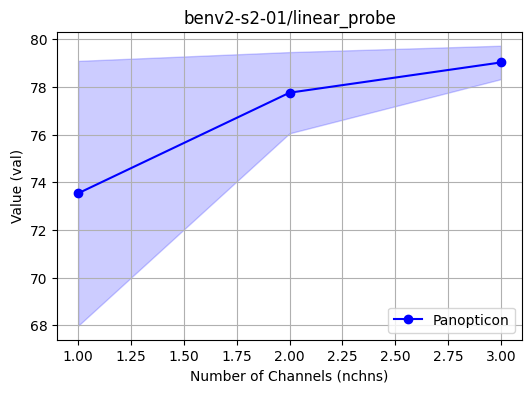

<Axes: title={'center': 'benv2-s2-01/linear_probe'}, xlabel='Number of Channels (nchns)', ylabel='Value (val)'>

In [ ]:
root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/investigate_chn_influence'
plot_spec_inv('benv2-s2-01/linear_probe', collect=False, root=root, metric='MulLabAvergPrec_micro')

nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,1
panopticon,5,5,5,5,1
senpamae,5,5,5,3,0


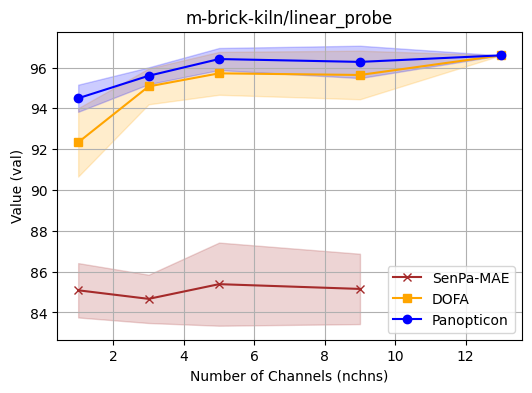

<Axes: title={'center': 'm-brick-kiln/linear_probe'}, xlabel='Number of Channels (nchns)', ylabel='Value (val)'>

In [4]:
plot_spec_inv('m-brick-kiln/linear_probe')

nchns,1,3,5,7,9,11,13
model,,,,,,,
dinov2,0,5,0,0,0,0,0
dofa,5,5,5,5,5,5,1
panopticon,5,5,5,5,5,5,1
senpamae,5,5,5,5,5,5,1


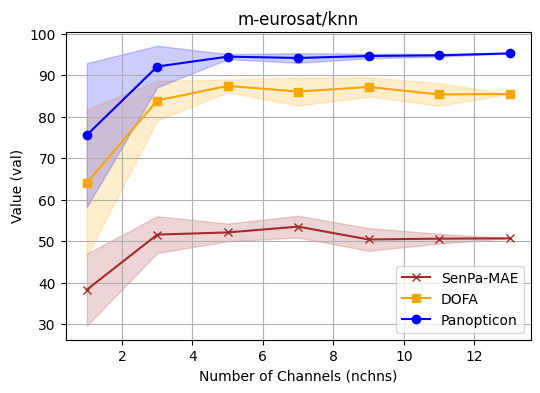

nchns,1,3,5,6
model,,,,
dinov2,0,5,0,0
dofa,5,5,5,1
panopticon,5,5,5,1
senpamae,5,5,5,1


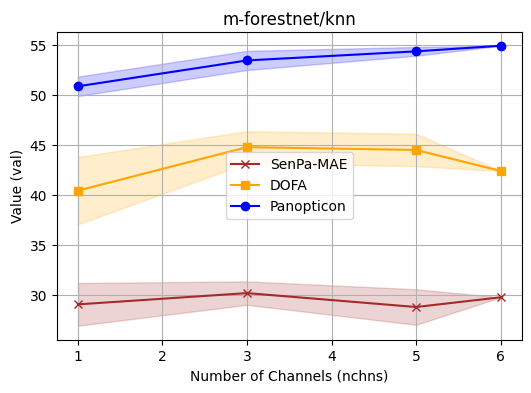

nchns,1,3,5,7,9,11,13
model,,,,,,,
dofa,5,5,5,5,5,5,1
panopticon,5,5,5,5,5,5,1
senpamae,5,5,5,5,5,5,1


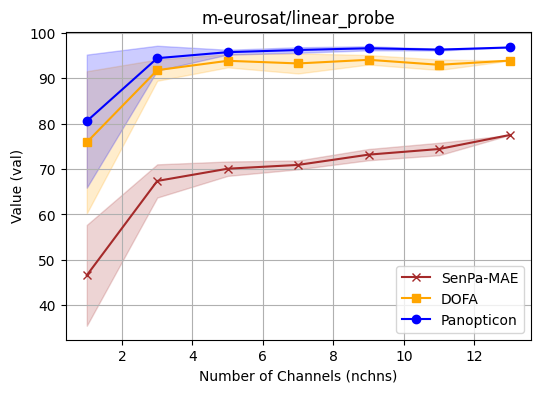

nchns,1,3,5,6
model,,,,
dofa,5,5,5,1
panopticon,5,5,5,1
senpamae,5,5,5,1


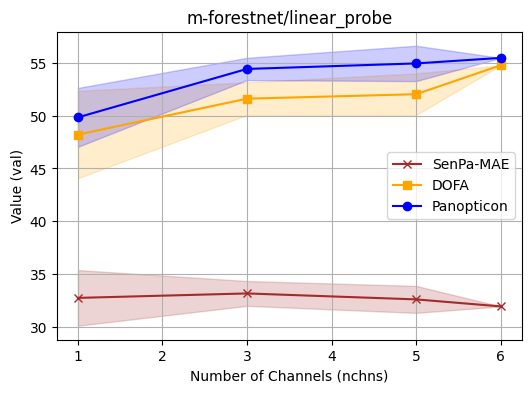

In [135]:
collect = False
eurosat_knn = plot_spec_inv('m-eurosat/knn', collect=collect)
plot_spec_inv('m-forestnet/knn', collect=collect)
eurosat_lin = plot_spec_inv('m-eurosat/linear_probe', collect=collect)
forestnet_lin = plot_spec_inv('m-forestnet/linear_probe', collect=collect)

nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,5
panopticon,5,5,5,5,5
senpamae,4,5,5,5,5


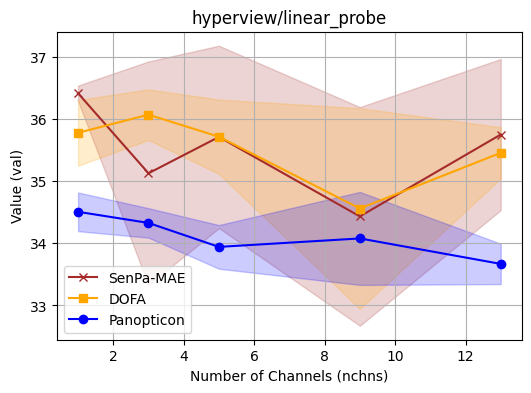

nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,3
panopticon,5,5,5,5,5
senpamae,5,2,3,4,5


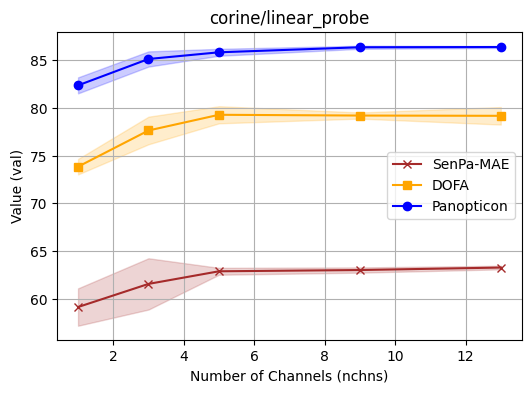

<Axes: title={'center': 'corine/linear_probe'}, xlabel='Number of Channels (nchns)', ylabel='Value (val)'>

In [186]:
plot_spec_inv('hyperview/linear_probe', metric='MSE')
plot_spec_inv('corine/linear_probe', metric='MulLabAvergPrec_micro')

nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,1
panopticon,5,5,5,5,1
senpamae,5,5,5,5,1


nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,3
panopticon,5,5,5,5,5
senpamae,5,5,5,5,5


nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,5
panopticon,5,5,5,5,5
senpamae,4,5,5,5,5


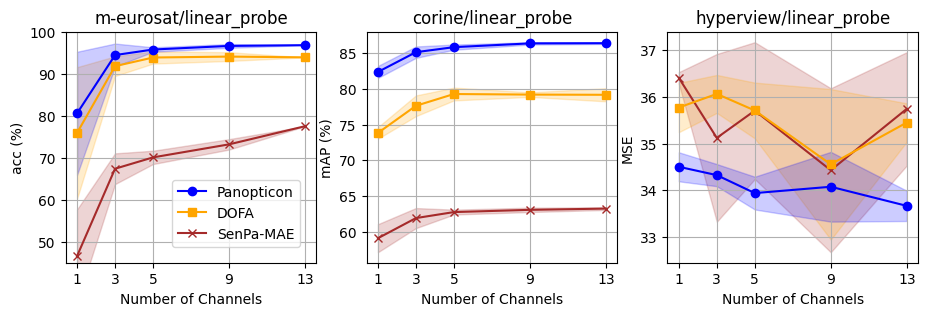

In [ ]:
import matplotlib.pyplot as plt
import os

fig, axes = plt.subplots(1, 3, figsize=(11, 3))

kwargs = dict(collect=True, dinov2=False, verbose=True, chn_ids=[1,3,5,9,13])

# plot_spec_inv('m-eurosat/knn', ax=axes[0], drop=('senpamae',1), **kwargs)
# # plot_spec_inv('m-eurosat/knn', ax=axes[0], **kwargs)
# axes[0].set_ylim(45,100)
# axes[0].set_ylabel('acc (%)')
# axes[0].set_xlabel('Number of Channels')

ax = axes[0]
plot_spec_inv('m-eurosat/linear_probe', ax=ax, **kwargs)
ax.set_ylim(45,100)
ax.set_ylabel('acc (%)')
ax.set_xlabel('Number of Channels')
ax.set_title('m-eurosat')

ax = axes[1]
plot_spec_inv('corine/linear_probe', metric='MulLabAvergPrec_micro', ax=ax, **kwargs)
ax.set_ylabel('mAP (%)')
ax.set_xlabel('Number of Channels')

ax = axes[2]
plot_spec_inv('hyperview/linear_probe', ax=ax, metric='MSE', **kwargs)
ax.set_ylabel('MSE')
ax.set_xlabel('Number of Channels')




# fig.suptitle('test')
fig.legend(
    handles=reversed(axes[0].get_legend_handles_labels()[0]), 
    labels=reversed(axes[0].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.28, 0.14), 
    ncol=1)
plt.show()

figroot = '/home/hk-project-pai00028/tum_mhj8661/code/z_figs'
fig.savefig(os.path.join(figroot,"spec_inv.pdf"), format="pdf", bbox_inches='tight')

In [169]:
""" generate random channel combinations"""

import numpy as np
import math

all_chns = 12
n_chns = [3]
subsets_per_n_chns = 100
with_ids = False

for chn in n_chns:
    already_used = set()
    n_subsets = min(
        subsets_per_n_chns, 
        math.factorial(all_chns) // (math.factorial(all_chns - chn) * math.factorial(chn)))
    for _ in range(n_subsets):
        def sample():
            l = np.random.choice(range(all_chns), chn, replace=False).tolist()
            l = sorted(l)
            return tuple(l)

        chns = sample()
        while chns in already_used:
            chns = sample()
        already_used.add(chns)

        if with_ids:
            print(f'  \"{chn:2d} {str(list(chns)).replace(" ","")}\"')
        else:
            print(f'  \"{str(list(chns)).replace(" ","")}\"')

  "[0,1,5]"
  "[2,5,10]"
  "[2,7,9]"
  "[5,7,11]"
  "[2,8,9]"
  "[0,3,10]"
  "[4,5,9]"
  "[7,9,11]"
  "[3,5,7]"
  "[0,2,8]"
  "[4,5,6]"
  "[0,6,7]"
  "[2,3,8]"
  "[6,9,10]"
  "[5,8,10]"
  "[2,4,9]"
  "[1,3,10]"
  "[1,8,11]"
  "[0,4,11]"
  "[0,7,10]"
  "[0,6,9]"
  "[0,5,8]"
  "[0,5,9]"
  "[4,5,11]"
  "[4,9,10]"
  "[2,6,10]"
  "[1,3,4]"
  "[1,8,9]"
  "[2,4,10]"
  "[1,2,7]"
  "[5,6,10]"
  "[0,1,2]"
  "[1,4,10]"
  "[2,4,7]"
  "[1,9,10]"
  "[3,8,9]"
  "[1,3,7]"
  "[1,6,7]"
  "[2,10,11]"
  "[8,9,11]"
  "[0,7,8]"
  "[5,6,7]"
  "[1,10,11]"
  "[2,9,11]"
  "[5,9,11]"
  "[1,5,7]"
  "[3,7,11]"
  "[3,7,10]"
  "[6,7,11]"
  "[1,6,10]"
  "[2,7,8]"
  "[8,10,11]"
  "[0,4,7]"
  "[3,7,8]"
  "[3,8,11]"
  "[4,6,10]"
  "[3,4,11]"
  "[1,7,10]"
  "[8,9,10]"
  "[0,3,5]"
  "[0,1,3]"
  "[4,6,11]"
  "[0,8,10]"
  "[2,3,6]"
  "[4,6,7]"
  "[1,2,9]"
  "[2,7,11]"
  "[6,7,10]"
  "[2,4,5]"
  "[3,5,10]"
  "[1,7,8]"
  "[9,10,11]"
  "[3,6,9]"
  "[3,4,6]"
  "[2,3,11]"
  "[5,6,11]"
  "[0,9,10]"
  "[0,1,8]"
  "[0,1,11]"
  "[1,

In [34]:
for i in np.linspace(0, 224, num=30):
    print(f'  \"[{int(i)}]\"')

  "[0]"
  "[7]"
  "[15]"
  "[23]"
  "[30]"
  "[38]"
  "[46]"
  "[54]"
  "[61]"
  "[69]"
  "[77]"
  "[84]"
  "[92]"
  "[100]"
  "[108]"
  "[115]"
  "[123]"
  "[131]"
  "[139]"
  "[146]"
  "[154]"
  "[162]"
  "[169]"
  "[177]"
  "[185]"
  "[193]"
  "[200]"
  "[208]"
  "[216]"
  "[224]"


### Dataset Debugging

In [1]:
from omegaconf import OmegaConf, open_dict
from geobreeze.factory import make_model

p = '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/config/model/base/panopticon.yaml'
cfg = OmegaConf.load(p)
with open_dict(cfg):
    cfg.blk_indices = cfg.blk_indices.linear_probe
model = make_model(cfg)

/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in /home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/panopticon-FM_panopticon_main
/home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/panopticon-FM_panopticon_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/pano

Loaded encoder with blocks [8, 9, 10, 11] blocks and norm LayerNorm((768,), eps=1e-06, elementwise_affine=True)


In [2]:
from geobreeze.factory import make_dataset
from omegaconf import OmegaConf

p = '/home/hk-project-pai00028/tum_mhj8661/code/segm_test.yaml'
cfg = OmegaConf.load(p)

ds = make_dataset(cfg.data.train, normalize=False)
x_dict, mask = ds[0]

/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


{'_target_': 'K.RandomHorizontalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'K.RandomVerticalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'K.Resize', 'size': 224, 'keepdim': True}


In [4]:
ds[0][0].keys()

dict_keys(['imgs', 'chn_ids'])

In [5]:
ds.calibrate(band_ids=[1,4,5])

INFO:eval:Subsampled 3/12 bands with ids [1, 4, 5]. Band names are:
  000: 02 - Blue
  001: 05 - Vegetation Red Edge
  002: 06 - Vegetation Red Edge


In [6]:
ds[0][0]['imgs'].shape

torch.Size([3, 224, 224])

In [7]:
ds[0][0]['chn_ids']

tensor([492.9971, 704.0059, 740.5521])

In [2]:
import os

root = '/home/hk-project-pai00028/tum_mhj8661/code/fm-playground/geofm_src/foundation_models/SenPaMAE/responsefunctions'
os.listdir(root)

['rfs_sentinel2_a.npy',
 'rfs_modis_terra.npy',
 'rfs_enmap_recon.npy',
 'rfs_wv23_recon.npy',
 'rfs_sentinel2_b.npy',
 'rfs_sentinel2_a_13b.npy',
 'rfs_landsat.npy',
 'rfs_superdove.npy']

In [5]:
import numpy as np

srfs = {}
for f in os.listdir(root):
    if f.endswith('.npy'):
        data = np.load(os.path.join(root,f))
        srfs[f.removesuffix('.npy')] = data

for f, d in srfs.items():
    print(f, d.shape)

rfs_sentinel2_a (2301, 10)
rfs_modis_terra (2301, 16)
rfs_enmap_recon (2301, 224)
rfs_wv23_recon (2301, 8)
rfs_sentinel2_b (2301, 10)
rfs_sentinel2_a_13b (2301, 13)
rfs_landsat (2301, 7)
rfs_superdove (2301, 8)


In [13]:
f1 = 'rfs_sentinel2_a'
f2 = 'rfs_sentinel2_a_13b'

out = np.ones([srfs[f1].shape[1], srfs[f2].shape[1]]) * -1
for i in range(srfs[f1].shape[1]):
    for j in range(srfs[f2].shape[1]):
        out[i,j] = np.allclose(srfs[f1][:,i], srfs[f2][:,j]) 

print(out)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [7]:
ds.calibrate(band_ids= None)

INFO:eval:Subsampled 12/12 bands with ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]. Band names are:
  000: 01 - Coastal aerosol
  001: 02 - Blue
  002: 03 - Green
  003: 04 - Red
  004: 05 - Vegetation Red Edge
  005: 06 - Vegetation Red Edge
  006: 07 - Vegetation Red Edge
  007: 08 - NIR
  008: 08A - Vegetation Red Edge
  009: 09 - Water vapour
  010: 11 - SWIR
  011: 12 - SWIR


In [9]:
metainfo = {
    'chn_ids': 'bands.gaussian.mu',
    'gsd': 'bands.GSD',
    'senpamae_srf_name': 'senpamae_srf_name'
}
ds.calibrate(metainfo=metainfo)

ds[0]

INFO:eval:Subsampled 12/12 bands with ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]. Band names are:
  000: 01 - Coastal aerosol
  001: 02 - Blue
  002: 03 - Green
  003: 04 - Red
  004: 05 - Vegetation Red Edge
  005: 06 - Vegetation Red Edge
  006: 07 - Vegetation Red Edge
  007: 08 - NIR
  008: 08A - Vegetation Red Edge
  009: 09 - Water vapour
  010: 11 - SWIR
  011: 12 - SWIR


({'imgs': tensor([[[ 326.0000,  326.0000,  318.8251,  ...,  330.0000,  330.0000,
             330.0000],
           [ 326.0000,  326.0000,  318.8251,  ...,  330.0000,  330.0000,
             330.0000],
           [ 326.0000,  326.0000,  318.8251,  ...,  330.0000,  330.0000,
             330.0000],
           ...,
           [ 316.0000,  316.0000,  319.4439,  ...,  282.0000,  282.0000,
             278.0001],
           [ 316.0000,  316.0000,  319.4439,  ...,  282.0000,  282.0000,
             278.0001],
           [ 316.0000,  316.0000,  319.4439,  ...,  282.0000,  282.0000,
             278.0001]],
  
          [[ 394.0000,  390.2780,  374.5471,  ...,  564.1841,  501.8976,
             480.0002],
           [ 403.7175,  376.9169,  374.3644,  ...,  522.4305,  516.6534,
             439.7141],
           [ 410.8700,  396.7253,  372.7646,  ...,  501.2694,  462.4356,
             443.7401],
           ...,
           [ 354.8159,  344.2336,  358.6949,  ...,  350.4633,  322.1515,
          

torch.Size([12, 224, 224])
torch.Size([224, 224])


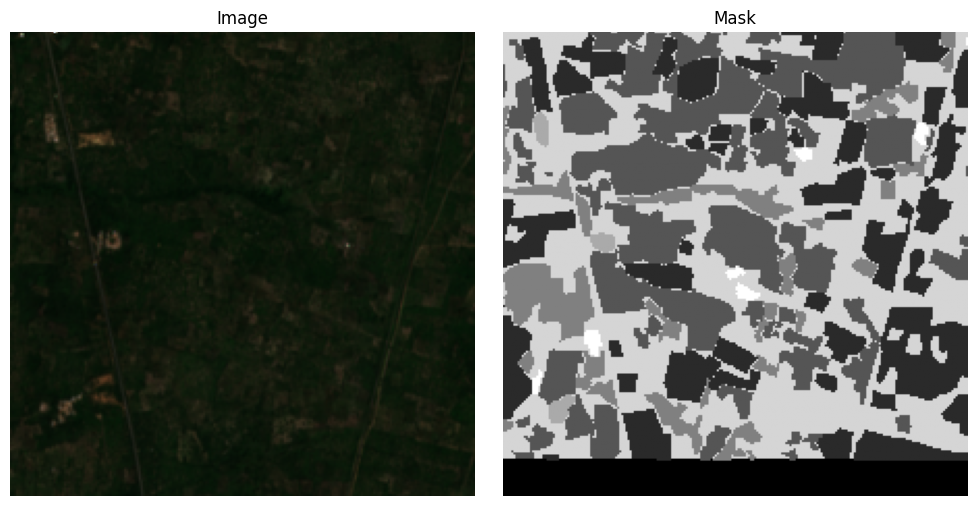

torch.Size([12, 224, 224])
torch.Size([224, 224])


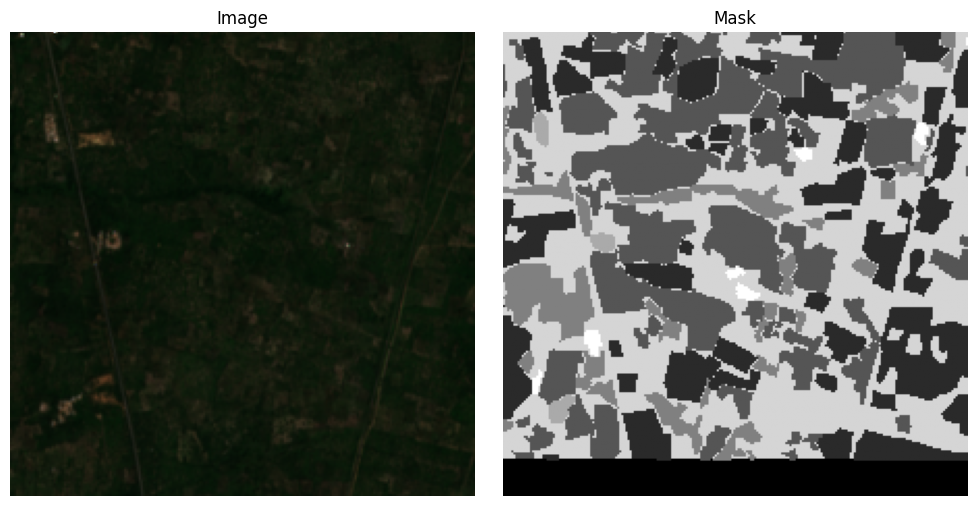

In [16]:
x_dict, mask = ds[100]


img = x_dict['imgs']
mask = mask
print(img.shape)
print(mask.shape)
img = img[[3,2,1]]

img = (img - img.min()) / (img.max() - img.min())

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
axes[0].imshow(img.permute(1, 2, 0).numpy())
axes[0].set_title("Image")
axes[0].axis("off")

# Plot the mask
axes[1].imshow(mask.numpy(), cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()



img = x_dict['imgs']
mask = mask
print(img.shape)
print(mask.shape)
img = img[[3,2,1]]

img = (img - img.min()) / (img.max() - img.min())

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
axes[0].imshow(img.permute(1, 2, 0).numpy())
axes[0].set_title("Image")
axes[0].axis("off")

# Plot the mask
axes[1].imshow(mask.numpy(), cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [11]:
import kornia as K
import torch

trf = K.augmentation.AugmentationSequential(
    K.augmentation.RandomVerticalFlip(p=1),
    data_keys=['input', 'label'],
)

x = torch.tensor([[1,1],[2,2,]], dtype=torch.float32)
y = torch.tensor([1], dtype=torch.int64)

print(x)

trf(x, y)   

tensor([[1., 1.],
        [2., 2.]])


[tensor([[[[2., 2.],
           [1., 1.]]]]),
 tensor([1])]

### gsd & spec invariance

In [126]:
import pandas as pd
from geobreeze.datasets.utils.utils import load_ds_cfg

collect = False

root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/spec_inv/'
ds_name = 'm-eurosat_1band/linear_probe'
metric = 'acc_top-1_micro'
dinov2 = True
chn_ids = None
drop = None
verbose = True

p = os.path.join(root, ds_name)
if collect:
    collect_csv(p)
df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


df = df[df['metric'] == metric]
df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
df['val'] = round(df['val']*100, 1)
df['chn_id'] = df['relpath'].apply(lambda x: int(x.split('/')[2].removeprefix('[').removesuffix(']')))
df = df.groupby(['model','chn_id'])['val'].agg(['max']).reset_index()
# display(df)


display(df.pivot(index='model', columns='chn_id', values='max'))
display(round(df.pivot(index='model', columns='chn_id', values='max') / df.pivot(index='model', columns='chn_id', values='max').mean(axis=1).values[:,None], 2))

bands = load_ds_cfg('m-eurosat')['bands']
gsds = [b['GSD'] for b in bands]

df['gsds'] = df['chn_id'].apply(lambda x: gsds[x])
round(df.groupby(['model','gsds'])['max'].agg(['mean','std','count','min','max']).reset_index(), 2)

chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,61.2,91.1,92.6,91.8,81.5,82.4,82.6,90.3,57.8,39.3,85.5,81.3,79.9
panopticon,67.3,92.1,94.0,92.5,89.5,86.5,87.3,93.0,63.2,40.6,86.4,88.6,89.1
senpamae,32.1,49.7,56.8,55.9,56.2,54.1,53.8,61.5,40.6,30.8,55.4,59.8,55.3


chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,0.78,1.16,1.18,1.17,1.04,1.05,1.06,1.15,0.74,0.50,1.09,1.04,1.02
panopticon,0.82,1.12,1.14,1.12,1.09,1.05,1.06,1.13,0.77,0.49,1.05,1.08,1.08
senpamae,0.63,0.98,1.12,1.10,1.10,1.06,1.06,1.21,0.80,0.60,1.09,1.17,1.09


,model,gsds,mean,std,count,min,max
0,dofa,10,91.45,0.98,4,90.3,92.6
1,dofa,20,77.58,9.74,6,57.8,82.6
2,dofa,60,62.00,23.11,3,39.3,85.5
3,panopticon,10,92.90,0.82,4,92.1,94.0
4,panopticon,20,84.03,10.27,6,63.2,89.5
5,panopticon,60,64.77,23.00,3,40.6,86.4
6,senpamae,10,55.98,4.85,4,49.7,61.5
7,senpamae,20,53.30,6.59,6,40.6,59.8
8,senpamae,60,39.43,13.84,3,30.8,55.4


In [166]:
""" these results are knn!"""
import os
import pandas as pd
from geobreeze.datasets.utils.utils import load_ds_cfg
from geobreeze.collect_results import collect_csv   

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_spec_inv/also_train/m-eurosat/'
# collect_csv(p)

df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


df = df[df['metric'] == 'acc_top-1_micro']
df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
df['train_mode'] = df['relpath'].apply(lambda x: x.split('/')[1])
df['prc'] = df['relpath'].apply(lambda x: float(x.split('/')[2]))
df['chn_id'] = df['relpath'].apply(lambda x: eval(x.split('/')[3]))


df = df[df['model'] == 'panopticon']
df = df[df['train_mode'] == 'knn']
df['nchns'] = df['chn_id'].apply(lambda x: len(x))

# df = df.groupby(['model','chn_id'])['val'].agg(['max']).reset_index()

df = df[df['nchns'] == 1]
df['chn_id'] = df['chn_id'].apply(lambda x: x[0])
df['prc'] = df['prc'].astype(float)
df = df[df['prc'] != 12.5]

dfp = df.pivot(index='prc', columns='chn_id', values='val')
dfp = round(dfp, 1)
dfp.sort_index(ascending=False, inplace=True)
display(dfp)

bands = load_ds_cfg('m-eurosat')['bands']
gsds = [b['GSD'] for b in bands]
df['native_gsd'] = df['chn_id'].apply(lambda x: gsds[x])
df['effective_gsd'] = (df['native_gsd'] / (df['prc']/100)).astype(int)

dfp = df.groupby(['native_gsd','effective_gsd'])['val'].agg(['mean','std','count','min','max']).reset_index()
dfp = dfp.pivot(index='native_gsd', columns='effective_gsd', values='mean')
dfp = round(dfp, 1)
# dfp.sort_index(ascending=False, inplace=True)
display(dfp)

display(dfp[[10,20,60]])

chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
prc,,,,,,,,,,,,,
100.0,58.6,89.0,89.7,90.0,84.8,84.4,85.3,92.0,55.3,39.0,81.7,83.2,83.1
50.0,58.6,85.1,86.9,86.4,83.1,83.4,82.6,88.3,53.1,37.0,79.9,82.9,82.6
33.3,58.5,79.5,80.9,79.8,81.1,78.2,78.0,81.4,52.9,35.3,77.5,77.8,76.9
25.0,57.8,73.3,76.7,74.9,77.4,75.5,74.0,74.6,52.6,36.9,73.9,74.7,73.9
16.6,57.2,66.9,68.7,68.7,68.2,65.8,65.3,65.4,51.5,34.8,67.3,69.5,64.5


effective_gsd,10,20,30,40,60,80,120,180,240,361
native_gsd,,,,,,,,,,
10,90.2,86.7,80.4,74.9,67.4,NaN,NaN,NaN,NaN,NaN
20,NaN,79.4,NaN,77.9,74.1,71.4,64.1,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,59.8,NaN,58.5,57.1,56.2,53.1


effective_gsd,10,20,60
native_gsd,,,
10,90.2,86.7,67.4
20,NaN,79.4,74.1
60,NaN,NaN,59.8


In [164]:
ids = [10,20,60]

all_tuples = []
for i in ids:
    for j in ids:
        for k in ids:
            all_tuples.append(sorted((i,j,k)))
print(len(all_tuples))
all_tuples = [list(x) for x in set(tuple(x) for x in all_tuples)]

print(len(all_tuples))
all_tuples

27
10


[[20, 20, 60],
 [10, 20, 60],
 [10, 10, 20],
 [20, 60, 60],
 [10, 10, 10],
 [20, 20, 20],
 [10, 20, 20],
 [10, 10, 60],
 [10, 60, 60],
 [60, 60, 60]]

In [ ]:
""" these results are knn!"""
import os
import pandas as pd
from geobreeze.datasets.utils.utils import load_ds_cfg
from geobreeze.collect_results import collect_csv   

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_inv2/also_train/m-eurosat_gsdinv/knn/'
# collect_csv(p)

df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


df = df[df['metric'] == 'acc_top-1_micro']
df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
# df['val'] = round(df['val']*100, 1)
df['prc'] = df['relpath'].apply(lambda x: float(x.split('/')[1]))
df['chn_id'] = df['relpath'].apply(lambda x: int(x.split('/')[2].removeprefix('[').removesuffix(']')))
# df = df.groupby(['model','chn_id'])['val'].agg(['max']).reset_index()


for prc in sorted(df['prc'].unique(), reverse=True):
    print(prc)
    plotdf = df[df['prc'] == prc]
    display(plotdf.pivot(index='model', columns='chn_id', values='val'))

50.0


chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,50.5,80.14,81.0,81.8,69.4,66.6,67.0,77.3,43.0,31.2,67.6,70.0,63.20
panopticon,58.6,85.10,86.9,86.4,83.1,83.4,82.6,88.3,53.1,37.0,79.9,82.9,82.56


25.0


chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,49.6,69.5,71.0,70.02,63.9,59.13,58.94,65.0,43.2,27.3,63.9,66.9,59.7
panopticon,57.8,73.3,76.7,74.90,77.4,75.46,74.05,74.6,52.6,36.9,73.9,74.7,73.9


16.6


chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,47.9,58.0,60.7,59.8,59.7,53.5,54.15,57.09,41.2,30.0,59.4,59.1,53.9
panopticon,57.2,66.9,68.7,68.7,68.2,65.8,65.30,65.41,51.5,34.8,67.3,69.5,64.5


12.5


chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,47.4,52.8,55.3,53.3,55.6,46.86,46.0,52.67,41.3,28.02,54.5,55.13,49.7
panopticon,54.1,58.0,59.9,59.8,63.8,57.20,57.4,56.21,49.4,34.40,61.1,64.50,57.3


In [2]:
import os
import pandas as pd
from geobreeze.datasets.utils.utils import load_ds_cfg
from geobreeze.collect_results import collect_csv   

root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_spec_inv/also_train/m-eurosat'
# collect_csv(root)

df = pd.read_csv(os.path.join(root,'results.csv')).drop(columns=['Unnamed: 0'])
df = df[df['metric'] == 'acc_top-1_micro']
df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
df['mode'] = df['relpath'].apply(lambda x: x.split('/')[1])
df = df[df['mode'] == 'linear_probe']

df['prc'] = df['relpath'].apply(lambda x: float(x.split('/')[2]))
df['nchns'] = df['relpath'].apply(lambda x: int(x.split('/')[3]))
df['chn_ids'] = df['relpath'].apply(lambda x: x.split('/')[4])

df = df.groupby(['model','chn_ids','nchns','prc'])['val'].agg(['max']).reset_index()
df.rename(columns={'max':'val'}, inplace=True)
df

KeyError: 'geobreeze.datasets'

In [54]:
# prc by chn id

for model in ['panopticon','dofa']:
    print('---------------')
    print(model)

    dfp1 = df.groupby(['model','nchns','prc'])['val'].agg(['mean','std']).reset_index()
    dfp1 = dfp1[dfp1['model'] == model]
    dfp = dfp1.pivot(columns='nchns', index='prc', values='mean').sort_index(ascending=False)
    display(round(dfp*100,1))

    nchns_corr = dfp1['nchns'].corr(dfp1['mean'])
    prc_corr = dfp1['prc'].astype(float).corr(dfp1['mean'])
    print(f"Correlation of nchns to val: {nchns_corr}")
    print(f"Correlation of prc to val: {prc_corr}")

---------------
panopticon


nchns,1,3,5,7,9,11,13
prc,,,,,,,
100.0,82.3,94.4,95.8,96.2,96.6,96.3,96.8
50.0,80.8,93.7,95.7,95.9,95.9,96.2,96.7
25.0,73.7,90.7,92.8,92.9,94.0,92.9,93.7
16.6,67.5,87.3,90.9,91.2,92.4,92.2,92.6


Correlation of nchns to val: 0.6477646415563819
Correlation of prc to val: 0.3183474909887122
---------------
dofa


nchns,1,3,5,7,9,11,13
prc,,,,,,,
100.0,78.3,91.8,93.9,93.3,94.1,93.0,93.9
50.0,76.6,91.1,92.6,91.8,92.6,92.0,92.3
25.0,70.6,87.6,89.1,89.4,89.6,90.1,91.3
16.6,65.0,83.8,86.7,87.9,88.2,88.6,89.8


Correlation of nchns to val: 0.640977173176033
Correlation of prc to val: 0.3428451125019032
